### Social determinants of health and chronic diseases

<span style="font-size:14px">
Analysis of the 2022 PLACES (Population Level Analysis and Community Estimates) data from the CDC and the 2020 American Community Survey
</span>

***Andre Nana***

#### 1. Purpose

<span style="font-size:14px">
In this notebook, we will analyze the 2022 PLACES (Population Level Analysis and Community Estimates) data from the CDC and the 2020 American Community Survey (ACS) data to explore social determinants of health and their relationship with chronic diseases. The analysis will focus on understanding how various social factors influence health outcomes in different communities. It will involve pulling the data from the ACS data from the Census API, cleaning, transforming and merging it with the PLACES dataset that was previously downloaded. Pulling the census data requires a key which is freely accessible after registration at https://api.census.gov/data/key_signup.html. We will perform exploratory data analysis (EDA) and visualization to gain insights into the data. We will later assess area-level associations between sdh and chronic illnesses. 
The data was analyzed using Python 313 on VS code.
</span>

<span style="font-size:12px">
Disclaimer:
This analysis is intended for educational and research purposes only and has not been peer-reviewed. While efforts have been made to ensure the accuracy of the methods and results, the author does not guarantee the correctness or completeness of the analysis. The author bears no responsibility or liability for any errors, omissions, or outcomes resulting from the use of this material. Use at your own discretion.


#### 2. Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tableone import TableOne
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.stats import chi2_contingency, kruskal
import missingno as msno # visualizing missing data
import requests
from census import Census      
from us import states
import warnings
warnings.filterwarnings("ignore") # Ignore warnings by adding a semiclon at the end of the line
from collections import OrderedDict # to maintain the order of columns


#### 3. Data import and manipulation

<span style="font-size:14px; font-weight:bold;">3.1. CDC PLACES data</span>


<span style="font-size:14px"> The PLACES (Population Level Analysis and Community Estimates) project is a collaboration between the CDC, the Robert Wood Johnson Foundation, and the CDC Foundation. It provides community health estimates at four geographic levels, including ZIP Code Tabulation Area (ZCTA). ZCTAs are approximate representations of ZIP Code service areas created by the U.S. Census Bureau to enable the mapping and analysis of ZIP code-based data. The 2022 release provides model-based estimates for 29 measures, covering health outcomes, preventive service use, health risk behaviors, and health status. The estimates are based on data from the BRFSS, Census Bureau, and American Community Survey. The data is available through the CDC PLACES Data Portal in Open Data and GIS-friendly formats accessible at https://www.cdc.gov/places/tools/data-portal.html. 
</span>



In [2]:
path_places = path_api = "C:/Users/nanaw/My Drive/Github repositories/My repositories/Python/Python-data-cleaning-merging-visualization-and-modeling/Data/places.csv"
places_long_original = pd.read_csv(path_places);
places_long_original.head()

,Year,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text
0,2020,1012,BRFSS,Health Outcomes,Depression among adults aged >=18 years,%,Crude prevalence,20.3,NaN,NaN,18.9,21.7,661,POINT (-72.8463546 42.38702227),1012,HLTHOUT,DEPRESSION,CrdPrv,Depression
1,2020,1013,BRFSS,Health Outcomes,Stroke among adults aged >=18 years,%,Crude prevalence,3.4,NaN,NaN,3.2,3.6,"23,188",POINT (-72.605886 42.14579571),1013,HLTHOUT,STROKE,CrdPrv,Stroke
2,2020,1020,BRFSS,Health Outcomes,Obesity among adults aged >=18 years,%,Crude prevalence,29.9,NaN,NaN,29.4,30.4,"29,668",POINT (-72.5627275 42.16399216),1020,HLTHOUT,OBESITY,CrdPrv,Obesity
3,2020,1026,BRFSS,Health Outcomes,Depression among adults aged >=18 years,%,Crude prevalence,20.3,NaN,NaN,18.9,21.6,946,POINT (-72.92024618 42.4633281),1026,HLTHOUT,DEPRESSION,CrdPrv,Depression
4,2020,1028,BRFSS,Health Outcomes,Obesity among adults aged >=18 years,%,Crude prevalence,26.9,NaN,NaN,26.0,28.0,"15,720",POINT (-72.499013 42.05963362),1028,HLTHOUT,OBESITY,CrdPrv,Obesity


***Note:***
<span style="font-size:14px"> 
This dataset is in long format and our variables of interest are within the "Measure"column. We will proceed with selecting the needed variables and reshaping the data to a wide format for easier analysis. Each value of the "Measure" column will become a separate column in the wide format, with the corresponding values filled in. This will allow us to analyze each health measure independently across different ZCTAs.</span>

```python



In [3]:
# checking the columns of the original dataset
places_long_original.columns

Index(['Year', 'LocationName', 'DataSource', 'Category', 'Measure',
       'Data_Value_Unit', 'Data_Value_Type', 'Data_Value',
       'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'Low_Confidence_Limit', 'High_Confidence_Limit', 'TotalPopulation',
       'Geolocation', 'LocationID', 'CategoryID', 'MeasureId',
       'DataValueTypeID', 'Short_Question_Text'],
      dtype='object')

In [4]:
# subsetting the columns of interest
places_long = places_long_original[['LocationName','Measure', 'Data_Value']]
places_long.head()

,LocationName,Measure,Data_Value
0,1012,Depression among adults aged >=18 years,20.3
1,1013,Stroke among adults aged >=18 years,3.4
2,1020,Obesity among adults aged >=18 years,29.9
3,1026,Depression among adults aged >=18 years,20.3
4,1028,Obesity among adults aged >=18 years,26.9


In [5]:
# Reshaping the data to wide format, using pivot
places_wide = places_long.pivot(index='LocationName', columns='Measure', values='Data_Value')
places_wide

Measure,All teeth lost among adults aged >=65 years,Arthritis among adults aged >=18 years,Binge drinking among adults aged >=18 years,Cancer (excluding skin cancer) among adults aged >=18 years,Cervical cancer screening among adult women aged 21-65 years,Cholesterol screening among adults aged >=18 years,Chronic kidney disease among adults aged >=18 years,Chronic obstructive pulmonary disease among adults aged >=18 years,Coronary heart disease among adults aged >=18 years,Current asthma among adults aged >=18 years,...,No leisure-time physical activity among adults aged >=18 years,Obesity among adults aged >=18 years,"Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening","Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years",Physical health not good for >=14 days among adults aged >=18 years,Sleeping less than 7 hours among adults aged >=18 years,Stroke among adults aged >=18 years,Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure,Visits to dentist or dental clinic among adults aged >=18 years,Visits to doctor for routine checkup within the past year among adults aged >=18 years
LocationName,,,,,,,,,,,,,,,,,,,,,
1001,13.3,29.5,15.9,8.4,85.6,91.8,3.1,6.4,7.0,10.8,...,20.3,27.9,55.9,45.5,9.3,33.5,3.2,77.9,74.7,77.3
1002,12.4,17.8,17.5,4.5,73.5,83.1,2.2,4.6,4.3,11.4,...,17.5,20.9,52.9,38.8,7.6,30.1,2.1,64.2,68.6,75.5
1003,NaN,5.4,19.8,0.6,46.7,65.2,1.1,3.0,1.1,14.8,...,19.7,19.7,NaN,NaN,7.1,33.1,0.7,17.7,55.4,72.3
1005,12.1,27.2,17.9,7.0,86.2,91.2,2.5,5.7,5.7,10.6,...,20.8,29.9,56.5,47.0,8.7,32.5,2.5,74.9,74.7,79.9
1007,9.2,22.7,17.8,6.4,85.4,92.0,2.2,4.7,4.7,10.1,...,15.3,22.9,57.4,44.8,7.5,30.0,2.1,71.1,75.9,76.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,8.3,26.0,18.0,8.4,81.8,93.4,2.7,5.8,6.6,8.3,...,17.9,28.0,38.9,35.0,9.0,27.3,2.8,72.1,71.9,66.4
99925,19.0,26.6,18.0,6.8,77.9,88.8,3.5,8.2,8.0,10.7,...,25.8,34.8,33.1,27.1,13.1,33.1,4.2,69.2,56.9,65.2
99926,24.3,24.0,19.4,5.6,77.2,86.2,3.5,8.0,7.6,11.8,...,27.9,37.5,26.7,23.3,14.0,36.1,4.5,64.9,52.1,64.3


In [6]:
# Checking the columns of the reshaped dataset
places_wide.columns

Index(['All teeth lost among adults aged >=65 years',
       'Arthritis among adults aged >=18 years',
       'Binge drinking among adults aged >=18 years',
       'Cancer (excluding skin cancer) among adults aged >=18 years',
       'Cervical cancer screening among adult women aged 21-65 years',
       'Cholesterol screening among adults aged >=18 years',
       'Chronic kidney disease among adults aged >=18 years',
       'Chronic obstructive pulmonary disease among adults aged >=18 years',
       'Coronary heart disease among adults aged >=18 years',
       'Current asthma among adults aged >=18 years',
       'Current lack of health insurance among adults aged 18-64 years',
       'Current smoking among adults aged >=18 years',
       'Depression among adults aged >=18 years',
       'Diagnosed diabetes among adults aged >=18 years',
       'Fair or poor self-rated health status among adults aged >=18 years',
       'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adul

<span style="font-size:14px">
In the new dataset places, we have reshaped the measures such that each one of them is a separate column that contains the crude prevalence for each LocationName (5 Digits ZIP Code Tabulation Area (ZCTA5) code). 
Location Name will be later used to merge with the ACS data.
We will now proceed with renaming the columns to make them more readable and easier to work with.
</span>

In [7]:
# Dictionary mapping long names to short, clean variable names
rename_dict = {
    'All teeth lost among adults aged >=65 years': 'edentulism_65plus',
    'Arthritis among adults aged >=18 years': 'arthritis',
    'Binge drinking among adults aged >=18 years': 'binge_drinking',
    'Cancer (excluding skin cancer) among adults aged >=18 years': 'cancer',
    'Cervical cancer screening among adult women aged 21-65 years': 'cervical_screening',
    'Cholesterol screening among adults aged >=18 years': 'cholesterol_screening',
    'Chronic kidney disease among adults aged >=18 years': 'ckd',
    'Chronic obstructive pulmonary disease among adults aged >=18 years': 'copd',
    'Coronary heart disease among adults aged >=18 years': 'chd',
    'Current asthma among adults aged >=18 years': 'asthma',
    'Current lack of health insurance among adults aged 18-64 years': 'no_insurance_18_64',
    'Current smoking among adults aged >=18 years': 'smoking',
    'Depression among adults aged >=18 years': 'depression',
    'Diagnosed diabetes among adults aged >=18 years': 'diabetes',
    'Fair or poor self-rated health status among adults aged >=18 years': 'poor_health',
    'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years': 'colorectal_screening',
    'High blood pressure among adults aged >=18 years': 'hypertension',
    'High cholesterol among adults aged >=18 years who have been screened in the past 5 years': 'high_cholesterol',
    'Mammography use among women aged 50-74 years': 'mammography',
    'Mental health not good for >=14 days among adults aged >=18 years': 'mental_distress',
    'No leisure-time physical activity among adults aged >=18 years': 'physical_inactivity',
    'Obesity among adults aged >=18 years': 'obesity',
    'Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening': 'preventive_men_65plus',
    'Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years': 'preventive_women_65plus',
    'Physical health not good for >=14 days among adults aged >=18 years': 'physical_distress',
    'Sleeping less than 7 hours among adults aged >=18 years': 'short_sleep',
    'Stroke among adults aged >=18 years': 'stroke',
    'Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure': 'bp_meds',
    'Visits to dentist or dental clinic among adults aged >=18 years': 'dental_visit',
    'Visits to doctor for routine checkup within the past year among adults aged >=18 years': 'routine_checkup'
}

# Rename the columns
places_final = places_wide.rename(columns=rename_dict)
places_final = places_final.round(3)

***Note:***
<span style="font-size:14px"> Here, we are ceating a custom function to glimpse the data, returning information of interest.

In [8]:
def glimpse(df: pd.DataFrame, n: int = 3, max_levels: int = 10) -> pd.DataFrame:
    """
    Summarize each column of a DataFrame.
    - Numeric: min/max/mean/median on non-missing values.
    - Categorical: top `max_levels` value percentages (+ 'Other' if needed), ignoring NA.
    - Always shows % Missing and sample (first n non-missing).
    """
    total_rows = len(df)
    rows = []

    for col in df.columns:
        s = df[col]
        dtype = s.dtype.name

        # Missingness
        n_missing = int(s.isna().sum())
        miss_pct = round((n_missing / total_rows) * 100, 2) if total_rows else 0.0

        # Non-missing slice
        nonnull = s.dropna()
        is_num = pd.api.types.is_numeric_dtype(s)
        is_cat = (not is_num) or pd.api.types.is_categorical_dtype(s) or pd.api.types.is_bool_dtype(s)

        # Numeric stats (ignore NA)
        min_val = max_val = mean_val = median_val = None
        if is_num and not nonnull.empty:
            min_val = nonnull.min().round(3)
            max_val = nonnull.max().round(3)
            mean_val = nonnull.mean().round(3)
            median_val = nonnull.median().round(3)

        # Categorical percentages (ignore NA)
        cat_perc = None
        if is_cat and not nonnull.empty:
            vc = (nonnull.value_counts(normalize=True) * 100).sort_values(ascending=False)
            if len(vc) > max_levels:
                top = vc.iloc[:max_levels]
                other = max(0.0, 100.0 - float(top.sum()))
                cat_perc = OrderedDict((k, round(float(v), 2)) for k, v in top.items())
                cat_perc["Other"] = round(other, 2)
            else:
                cat_perc = OrderedDict((k, round(float(v), 2)) for k, v in vc.items())

        # Sample values (first n non-missing)
        k = min(n, len(nonnull))
        sample_vals = nonnull.head(k).tolist()

        rows.append({
            "Column": col,
            "Dtype": dtype,
             "% Missing": miss_pct,
            "Min": min_val,
            "Max": max_val,
            "Mean": mean_val,
            "Median": median_val,
            "Value % (top)": cat_perc,   # dict of value -> percent for categorical cols
            f"Sample (first {k})": sample_vals
        })

    return pd.DataFrame(rows)

In [9]:
glimpse(places_final, n=3)

,Column,Dtype,% Missing,Min,Max,Mean,Median,Value % (top),Sample (first 3)
0,edentulism_65plus,float64,0.55,3.3,53.9,15.395,14.6,None,"[13.3, 12.4, 12.1]"
1,arthritis,float64,0.00,1.7,66.0,26.700,27.0,None,"[29.5, 17.8, 5.4]"
2,binge_drinking,float64,0.00,2.1,40.4,16.849,16.7,None,"[15.9, 17.5, 19.8]"
3,cancer,float64,0.00,0.5,22.5,6.850,6.9,None,"[8.4, 4.5, 0.6]"
4,cervical_screening,float64,0.03,41.9,90.9,81.757,82.1,None,"[85.6, 73.5, 46.7]"
5,cholesterol_screening,float64,1.81,53.8,98.8,89.312,89.6,None,"[91.8, 83.1, 65.2]"
6,ckd,float64,0.00,0.5,10.7,3.121,3.1,None,"[3.1, 2.2, 1.1]"
7,copd,float64,0.00,0.7,25.7,7.831,7.6,None,"[6.4, 4.6, 3.0]"
8,chd,float64,0.00,0.5,23.8,7.050,7.1,None,"[7.0, 4.3, 1.1]"
9,asthma,float64,0.00,4.9,21.1,10.053,9.9,None,"[10.8, 11.4, 14.8]"


In [10]:
places_final

Measure,edentulism_65plus,arthritis,binge_drinking,cancer,cervical_screening,cholesterol_screening,ckd,copd,chd,asthma,...,physical_inactivity,obesity,preventive_men_65plus,preventive_women_65plus,physical_distress,short_sleep,stroke,bp_meds,dental_visit,routine_checkup
LocationName,,,,,,,,,,,,,,,,,,,,,
1001,13.3,29.5,15.9,8.4,85.6,91.8,3.1,6.4,7.0,10.8,...,20.3,27.9,55.9,45.5,9.3,33.5,3.2,77.9,74.7,77.3
1002,12.4,17.8,17.5,4.5,73.5,83.1,2.2,4.6,4.3,11.4,...,17.5,20.9,52.9,38.8,7.6,30.1,2.1,64.2,68.6,75.5
1003,NaN,5.4,19.8,0.6,46.7,65.2,1.1,3.0,1.1,14.8,...,19.7,19.7,NaN,NaN,7.1,33.1,0.7,17.7,55.4,72.3
1005,12.1,27.2,17.9,7.0,86.2,91.2,2.5,5.7,5.7,10.6,...,20.8,29.9,56.5,47.0,8.7,32.5,2.5,74.9,74.7,79.9
1007,9.2,22.7,17.8,6.4,85.4,92.0,2.2,4.7,4.7,10.1,...,15.3,22.9,57.4,44.8,7.5,30.0,2.1,71.1,75.9,76.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,8.3,26.0,18.0,8.4,81.8,93.4,2.7,5.8,6.6,8.3,...,17.9,28.0,38.9,35.0,9.0,27.3,2.8,72.1,71.9,66.4
99925,19.0,26.6,18.0,6.8,77.9,88.8,3.5,8.2,8.0,10.7,...,25.8,34.8,33.1,27.1,13.1,33.1,4.2,69.2,56.9,65.2
99926,24.3,24.0,19.4,5.6,77.2,86.2,3.5,8.0,7.6,11.8,...,27.9,37.5,26.7,23.3,14.0,36.1,4.5,64.9,52.1,64.3


<span style="font-size:14px"> The dataset looks reasonable with fewer missing values.

In [11]:
places_final.shape

(32409, 30)

<span style="font-size:14px">We have a final dataset of 30 variables and 32409 observations

<span style="font-size:14px; font-weight:bold;">3.2. American Community Survey</span>


<span style="font-size:14px">
The American Community Survey (ACS) is an ongoing national survey conducted by the U.S. Census Bureau that collects detailed demographic, social, economic, and housing information from millions of households each year. Unlike the decennial census, which provides a snapshot every ten years, the ACS delivers updated estimates annually, making it a vital resource for understanding population trends and community needs across all geographic levels—including states, counties, and ZIP Code Tabulation Areas. Its data informs decisions in public policy, business development, education, health, and infrastructure planning, and is available in both 1-year and 5-year estimates depending on population size and geographic coverage.
</span>

```python

In [12]:
# We will use the Census API to retrieve the American Community Survey (ACS) data for the year 2020. The ACS provides detailed demographic, social, economic, and housing information from millions of households across the United States.
# To access the ACS data, we need a personal API key from the U.S. Census Bureau. This key allows us to make requests to the Census API and retrieve the data we need for
# The personal API key is stored in a file named 'API.txt'.
path_api = "C:/Users/nanaw/My Drive/Github repositories/My repositories/Python/Python-data-cleaning-merging-visualization-and-modeling/Data/API.txt"
with open(path_api, 'r') as file:
    api_key = file.read().strip()

# Initialize Census object
c = Census(api_key)

In [13]:
# Getting the variables metadata for ACS 5-Year 2020
url = "https://api.census.gov/data/2020/acs/acs5/variables.json"
resp = requests.get(url)
variables = resp.json()['variables']

# Convert to DataFrame
acs2020_var = pd.DataFrame.from_dict(variables, orient='index').reset_index()
acs2020_var = acs2020_var.rename(columns={'index': 'variable'})

# Preview
print(acs2020_var[['variable', 'label']].head())

       variable                                              label
0           for                       Census API FIPS 'for' clause
1            in                        Census API FIPS 'in' clause
2         ucgid         Uniform Census Geography Identifier clause
3   B24022_060E  Estimate!!Total:!!Female:!!Service occupations...
4  B19001B_014E             Estimate!!Total:!!$100,000 to $124,999


In [14]:
# Checking the columns of the ACS variables DataFrame
acs2020_var

,variable,label,concept,predicateType,group,limit,predicateOnly,hasGeoCollectionSupport,attributes,required
0,for,Census API FIPS 'for' clause,Census API Geography Specification,fips-for,N/A,0,True,NaN,NaN,NaN
1,in,Census API FIPS 'in' clause,Census API Geography Specification,fips-in,N/A,0,True,NaN,NaN,NaN
2,ucgid,Uniform Census Geography Identifier clause,Census API Geography Specification,ucgid,N/A,0,True,True,NaN,NaN
3,B24022_060E,Estimate!!Total:!!Female:!!Service occupations...,SEX BY OCCUPATION AND MEDIAN EARNINGS IN THE P...,int,B24022,0,NaN,NaN,"B24022_060EA,B24022_060M,B24022_060MA",NaN
4,B19001B_014E,"Estimate!!Total:!!$100,000 to $124,999",HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 202...,int,B19001B,0,NaN,NaN,"B19001B_014EA,B19001B_014M,B19001B_014MA",NaN
...,...,...,...,...,...,...,...,...,...,...
27887,B25124_022E,Estimate!!Total:!!Owner occupied:!!3-person ho...,TENURE BY HOUSEHOLD SIZE BY UNITS IN STRUCTURE,int,B25124,0,NaN,NaN,"B25124_022EA,B25124_022M,B25124_022MA",NaN
27888,B20005I_071E,"Estimate!!Total:!!Female:!!Worked full-time, y...",SEX BY WORK EXPERIENCE IN THE PAST 12 MONTHS B...,int,B20005I,0,NaN,NaN,"B20005I_071EA,B20005I_071M,B20005I_071MA",NaN
27889,B08113_054E,Estimate!!Total:!!Worked from home:!!Speak oth...,MEANS OF TRANSPORTATION TO WORK BY LANGUAGE SP...,int,B08113,0,NaN,NaN,"B08113_054EA,B08113_054M,B08113_054MA",NaN
27890,B06009_006E,Estimate!!Total:!!Graduate or professional degree,PLACE OF BIRTH BY EDUCATIONAL ATTAINMENT IN TH...,int,B06009,0,NaN,NaN,"B06009_006EA,B06009_006M,B06009_006MA",NaN


<span style="font-size:14px">
Here we will select and rename variables of interest, then pull the data at the ZCTA level. This will allow us to merge the ACS data with the PLACES data later on. The variables selected include demographic, social, economic, and housing characteristics that are relevant for understanding community health and social determinants of health.
</span>

```python

In [15]:
# Define ACS variable codes
VARIABLES = [
    'NAME',
    'ZCTA',
    'B19013_001E',  # Median household income
    'B01003_001E',  # Total population
    'B17001_002E',  # Below poverty line
    'B23025_005E',  # Unemployed
    'B23025_003E',  # Labor force
    'B15003_002E', 'B15003_003E', 'B15003_004E', 'B15003_005E',  # < high school
    'B15003_006E', 'B15003_007E', 'B15003_008E', 'B15003_009E',
    'B15003_010E', 'B15003_011E', 'B15003_012E', 'B15003_013E',
    'B15003_014E', 'B15003_015E', 'B15003_016E',
    'B25003_001E',  # Total occupied housing
    'B25003_003E',  # Renter-occupied
    'B08201_002E',  # No vehicle available
    'B27010_017E'   # Uninsured 18–24
]

# Query ZIP-level data
data = c.acs5.get(
    VARIABLES,
    {'for': 'zip code tabulation area:*'},
    year=2020
)

# Convert to DataFrame
acs_2020 = pd.DataFrame(data)

# Rename key variables
acs_2020 = acs_2020.rename(columns={
    'B19013_001E': 'Median_Household_Income',
    'B01003_001E': 'Total_Population',
    'B17001_002E': 'Below_Poverty_Count',
    'B23025_005E': 'Unemployed_Count',
    'B23025_003E': 'Labor_Force',
    'B25003_001E': 'Total_Occupied_Housing',
    'B25003_003E': 'Renter_Occupied',
    'B08201_002E': 'No_Vehicle_Available',
    'B27010_017E': 'Uninsured_18_24'
})

# Add derived: No high school diploma (sum of B15003_002E to _016E)
hs_fields = [f'B15003_{str(i).zfill(3)}E' for i in range(2, 17)]
acs_2020[hs_fields] = acs_2020[hs_fields].apply(pd.to_numeric, errors='coerce')
acs_2020['No_High_School_Diploma'] = acs_2020[hs_fields].sum(axis=1)

# Convert other relevant columns to numeric
to_numeric = [
    'Median_Household_Income', 'Total_Population', 'Below_Poverty_Count',
    'Unemployed_Count', 'Labor_Force', 'Renter_Occupied',
    'Total_Occupied_Housing', 'No_Vehicle_Available', 'Uninsured_18_24'
]
acs_2020[to_numeric] = acs_2020[to_numeric].apply(pd.to_numeric, errors='coerce')

# Drop individual B15003_x variables to clean up
acs_2020.drop(columns=hs_fields, inplace=True)


# Create percentage variables
acs_2020['Pct_Below_Poverty'] = (acs_2020['Below_Poverty_Count'] / acs_2020['Total_Population']) * 100
acs_2020['Pct_Unemployed'] = (acs_2020['Unemployed_Count'] / acs_2020['Labor_Force']) * 100
acs_2020['Pct_No_High_School_Diploma'] = (acs_2020['No_High_School_Diploma'] / acs_2020['Total_Population']) * 100
acs_2020['Pct_Renter_Occupied'] = (acs_2020['Renter_Occupied'] / acs_2020['Total_Occupied_Housing']) * 100
acs_2020['Pct_No_Vehicle'] = (acs_2020['No_Vehicle_Available'] / acs_2020['Total_Occupied_Housing']) * 100
acs_2020['Pct_Uninsured_18_24'] = (acs_2020['Uninsured_18_24'] / acs_2020['Total_Population']) * 100  # Approximation

# Rounding to 3 decimal places
acs_2020[['Pct_Below_Poverty', 'Pct_Unemployed', 'Pct_No_High_School_Diploma',
          'Pct_Renter_Occupied', 'Pct_No_Vehicle', 'Pct_Uninsured_18_24']] = (
    acs_2020[['Pct_Below_Poverty', 'Pct_Unemployed', 'Pct_No_High_School_Diploma',
              'Pct_Renter_Occupied', 'Pct_No_Vehicle', 'Pct_Uninsured_18_24']]
    .round(3)
)

# Select relevant columns for final DataFrame
acs_final = acs_2020[['ZCTA', 'Median_Household_Income',
                'Pct_Below_Poverty', 'Pct_Unemployed',
                'Pct_No_High_School_Diploma', 'Pct_Renter_Occupied',
                'Pct_No_Vehicle', 'Pct_Uninsured_18_24']]


In [16]:
# Checking the ACS data with the selected variables
acs_final

,ZCTA,Median_Household_Income,Pct_Below_Poverty,Pct_Unemployed,Pct_No_High_School_Diploma,Pct_Renter_Occupied,Pct_No_Vehicle,Pct_Uninsured_18_24
0,29590,30985.0,24.527,4.000,17.810,23.225,6.795,0.000
1,93306,54450.0,21.338,7.651,14.876,36.825,4.510,0.984
2,93660,39625.0,25.894,14.851,30.402,58.377,9.273,0.955
3,93110,93264.0,8.443,3.585,6.155,37.087,5.074,0.507
4,93212,42983.0,17.308,11.366,29.156,52.342,12.606,0.288
...,...,...,...,...,...,...,...,...
33115,16623,51667.0,14.493,8.219,6.884,11.574,2.778,0.000
33116,16627,45000.0,15.297,11.151,6.610,10.795,5.795,0.519
33117,16634,51500.0,7.619,13.014,13.651,10.274,4.110,0.000
33118,16640,55982.0,23.621,4.317,4.102,9.030,0.669,3.112


In [17]:
# glimpsing acs_final
glimpse(acs_final, n=3)

,Column,Dtype,% Missing,Min,Max,Mean,Median,Value % (top),Sample (first 3)
0,ZCTA,object,0.00,NaN,NaN,NaN,NaN,"{'26222': 0.0, '26236': 0.0, '26237': 0.0, '26...","[29590, 93306, 93660]"
1,Median_Household_Income,float64,0.00,-666666666.0,250001.000,-5.139071e+07,55873.500,None,"[30985.0, 54450.0, 39625.0]"
2,Pct_Below_Poverty,float64,1.12,0.0,100.000,1.294700e+01,10.482,None,"[24.527, 21.338, 25.894]"
3,Pct_Unemployed,float64,1.85,0.0,100.000,5.431000e+00,4.239,None,"[4.0, 7.651, 14.851]"
4,Pct_No_High_School_Diploma,float64,1.12,0.0,100.000,8.107000e+00,6.473,None,"[17.81, 14.876, 30.402]"
5,Pct_Renter_Occupied,float64,1.90,0.0,100.000,2.622400e+01,22.842,None,"[23.225, 36.825, 58.377]"
6,Pct_No_Vehicle,float64,1.90,0.0,100.000,6.197000e+00,3.872,None,"[6.795, 4.51, 9.273]"
7,Pct_Uninsured_18_24,float64,1.12,0.0,74.138,1.273000e+00,0.520,None,"[0.0, 0.984, 0.955]"


<span style="font-size:14px"> There is an unusual value for the variable Median_Household_Income. We will replace it with NaN and check again.

In [18]:
acs_final['Median_Household_Income'] = acs_final['Median_Household_Income'].replace(-666666666.0, np.nan)

In [19]:
glimpse(acs_final, n=3)

,Column,Dtype,% Missing,Min,Max,Mean,Median,Value % (top),Sample (first 3)
0,ZCTA,object,0.00,NaN,NaN,NaN,NaN,"{'26222': 0.0, '26236': 0.0, '26237': 0.0, '26...","[29590, 93306, 93660]"
1,Median_Household_Income,float64,7.72,2499.0,250001.000,63463.601,57857.000,None,"[30985.0, 54450.0, 39625.0]"
2,Pct_Below_Poverty,float64,1.12,0.0,100.000,12.947,10.482,None,"[24.527, 21.338, 25.894]"
3,Pct_Unemployed,float64,1.85,0.0,100.000,5.431,4.239,None,"[4.0, 7.651, 14.851]"
4,Pct_No_High_School_Diploma,float64,1.12,0.0,100.000,8.107,6.473,None,"[17.81, 14.876, 30.402]"
5,Pct_Renter_Occupied,float64,1.90,0.0,100.000,26.224,22.842,None,"[23.225, 36.825, 58.377]"
6,Pct_No_Vehicle,float64,1.90,0.0,100.000,6.197,3.872,None,"[6.795, 4.51, 9.273]"
7,Pct_Uninsured_18_24,float64,1.12,0.0,74.138,1.273,0.520,None,"[0.0, 0.984, 0.955]"


In [20]:
acs_final.shape

(33120, 8)

<span style="font-size:14px">The resulting dataset looks reasonable, with 8 columns and 33120 observations

<span style="font-size:14px; font-weight:bold;">3.3. Merging the 2 datasets</span>


Note:
<span style="font-size:14px"> We will proceed with an inner join on the LocationName column from the PLACES dataset and the ZCTA5 column from the ACS dataset. This will ensure that we only keep the ZCTAs that are present in both datasets.

In [21]:
# Let's brings 'LocationName' back as a column and not as an index - necessary for merging
places_final = places_final.reset_index()  

# Ensure ZCTA and LocationName are string and zero-padded
acs_final['ZCTA'] = acs_final['ZCTA'].astype(str).str.zfill(5)
places_final['LocationName'] = places_final['LocationName'].astype(str).str.zfill(5)

# Merge ACS and Places data on ZCTA
merged_original = pd.merge(
    acs_final,
    places_final,
    left_on='ZCTA',
    right_on='LocationName',
    how='inner'  
)
merged_original = merged_original.drop(columns=['LocationName'])

In [22]:
merged_original

,ZCTA,Median_Household_Income,Pct_Below_Poverty,Pct_Unemployed,Pct_No_High_School_Diploma,Pct_Renter_Occupied,Pct_No_Vehicle,Pct_Uninsured_18_24,edentulism_65plus,arthritis,...,physical_inactivity,obesity,preventive_men_65plus,preventive_women_65plus,physical_distress,short_sleep,stroke,bp_meds,dental_visit,routine_checkup
0,29590,30985.0,24.527,4.000,17.810,23.225,6.795,0.000,24.4,27.0,...,35.4,46.7,32.5,30.4,13.6,41.6,4.7,74.2,51.7,79.8
1,93306,54450.0,21.338,7.651,14.876,36.825,4.510,0.984,15.6,20.9,...,27.5,34.4,34.9,27.0,12.9,33.9,3.2,69.0,55.5,67.7
2,93660,39625.0,25.894,14.851,30.402,58.377,9.273,0.955,22.6,19.0,...,37.5,40.5,20.5,17.5,15.9,34.7,3.1,56.7,40.4,62.4
3,93110,93264.0,8.443,3.585,6.155,37.087,5.074,0.507,8.4,22.4,...,17.0,26.9,40.6,36.1,8.9,27.1,2.6,71.4,71.8,68.3
4,93212,42983.0,17.308,11.366,29.156,52.342,12.606,0.288,23.6,18.9,...,34.8,42.4,25.3,21.4,15.5,39.6,3.6,59.9,40.1,63.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32404,16623,51667.0,14.493,8.219,6.884,11.574,2.778,0.000,16.7,31.3,...,26.8,36.2,42.9,37.1,12.2,36.6,3.5,78.0,60.7,76.6
32405,16627,45000.0,15.297,11.151,6.610,10.795,5.795,0.519,18.1,31.6,...,26.8,34.5,37.9,36.3,12.7,37.1,3.8,77.8,60.6,78.8
32406,16634,51500.0,7.619,13.014,13.651,10.274,4.110,0.000,17.2,31.1,...,27.0,36.7,43.2,33.5,12.4,36.9,3.6,77.8,59.7,76.2
32407,16640,55982.0,23.621,4.317,4.102,9.030,0.669,3.112,15.9,34.2,...,26.6,33.2,36.5,34.2,12.7,36.8,3.8,80.3,62.7,77.6


<span style="font-size:14px">The merged dataset expectedly has 38 columns and 32409 observations.

#### 4. Exploratory data analysis (EDA)

<span style="font-size:14px; font-weight:bold;">4.1. Overview of the merged dataset</span>


In [23]:
glimpse(merged_original)

,Column,Dtype,% Missing,Min,Max,Mean,Median,Value % (top),Sample (first 3)
0,ZCTA,object,0.00,NaN,NaN,NaN,NaN,"{'84601': 0.0, '17062': 0.0, '29590': 0.0, '93...","[29590, 93306, 93660]"
1,Median_Household_Income,float64,6.33,2499.0,250001.000,63634.036,57985.000,None,"[30985.0, 54450.0, 39625.0]"
2,Pct_Below_Poverty,float64,0.31,0.0,100.000,12.822,10.490,None,"[24.527, 21.338, 25.894]"
3,Pct_Unemployed,float64,0.85,0.0,100.000,5.387,4.247,None,"[4.0, 7.651, 14.851]"
4,Pct_No_High_School_Diploma,float64,0.31,0.0,100.000,8.061,6.481,None,"[17.81, 14.876, 30.402]"
5,Pct_Renter_Occupied,float64,1.04,0.0,100.000,26.199,22.840,None,"[23.225, 36.825, 58.377]"
6,Pct_No_Vehicle,float64,1.04,0.0,100.000,6.151,3.888,None,"[6.795, 4.51, 9.273]"
7,Pct_Uninsured_18_24,float64,0.31,0.0,74.138,1.278,0.531,None,"[0.0, 0.984, 0.955]"
8,edentulism_65plus,float64,0.55,3.3,53.900,15.395,14.600,None,"[24.4, 15.6, 22.6]"
9,arthritis,float64,0.00,1.7,66.000,26.700,27.000,None,"[27.0, 20.9, 19.0]"


<span style="font-size:14px"> Median_Household_Income is the variable with the highest number of missing values.

<span style="font-size:14px; font-weight:bold;">4.2. Pairwise comparison of missing data</span>


Axes(0.125,0.11;0.62x0.77)


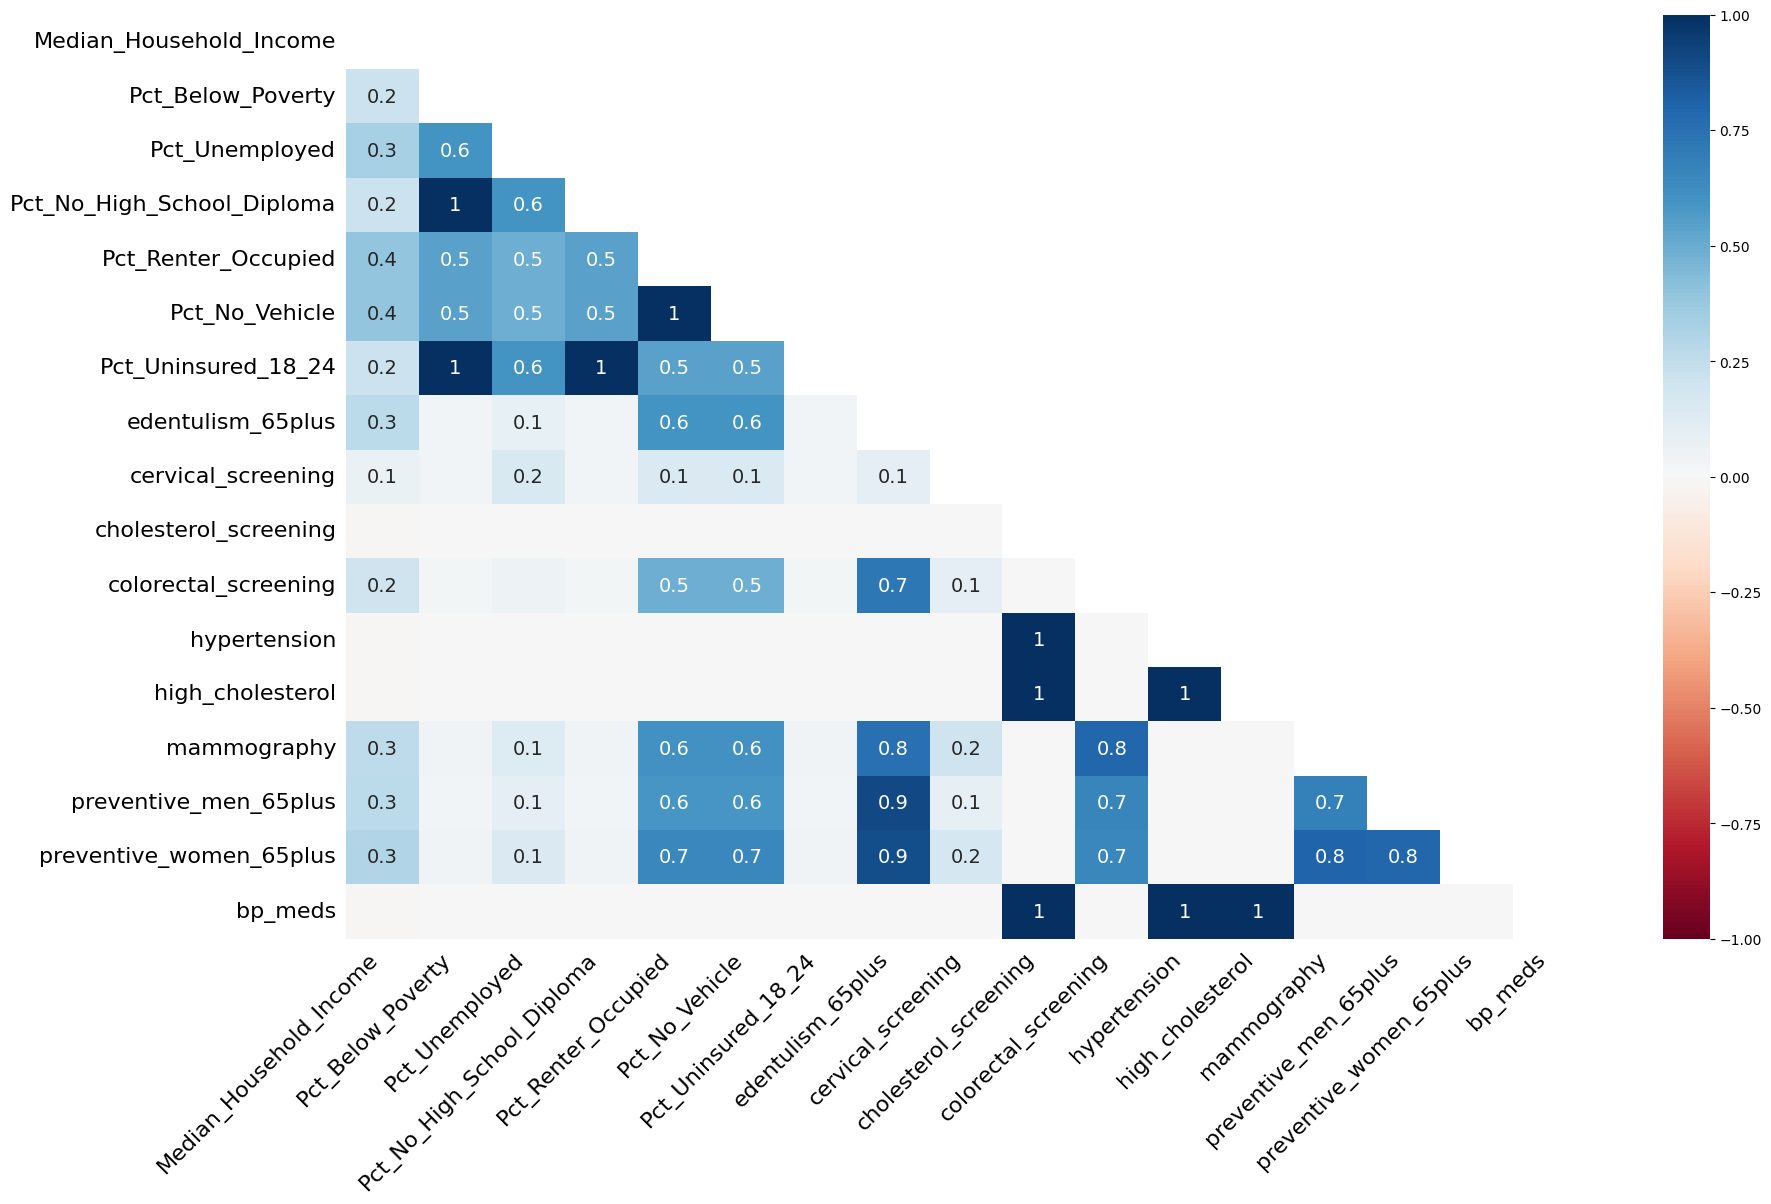

In [24]:
print(msno.heatmap(merged_original))

<span style="font-size:14px"> 
Each cell in the heatmap shows the nullity correlation between two columns:

- 1.0 means the two columns have missing values in the same places.
- 0.5 means the two columns are missing at the same time in half of the cases.
- 0.0 means the missing values are completely independent.
- -1.0 means the two columns are never missing at the same time.

<span style="font-size:14px"> 
Variables with a perfect correlation (1.0) in missing values include for instance:

- 'Pct_No_High_School_Diploma' & 'Pct_Below_Poverty'
- 'Pct_Uninsured_18_24' & 'Pct_Below_Poverty'


<Axes: >

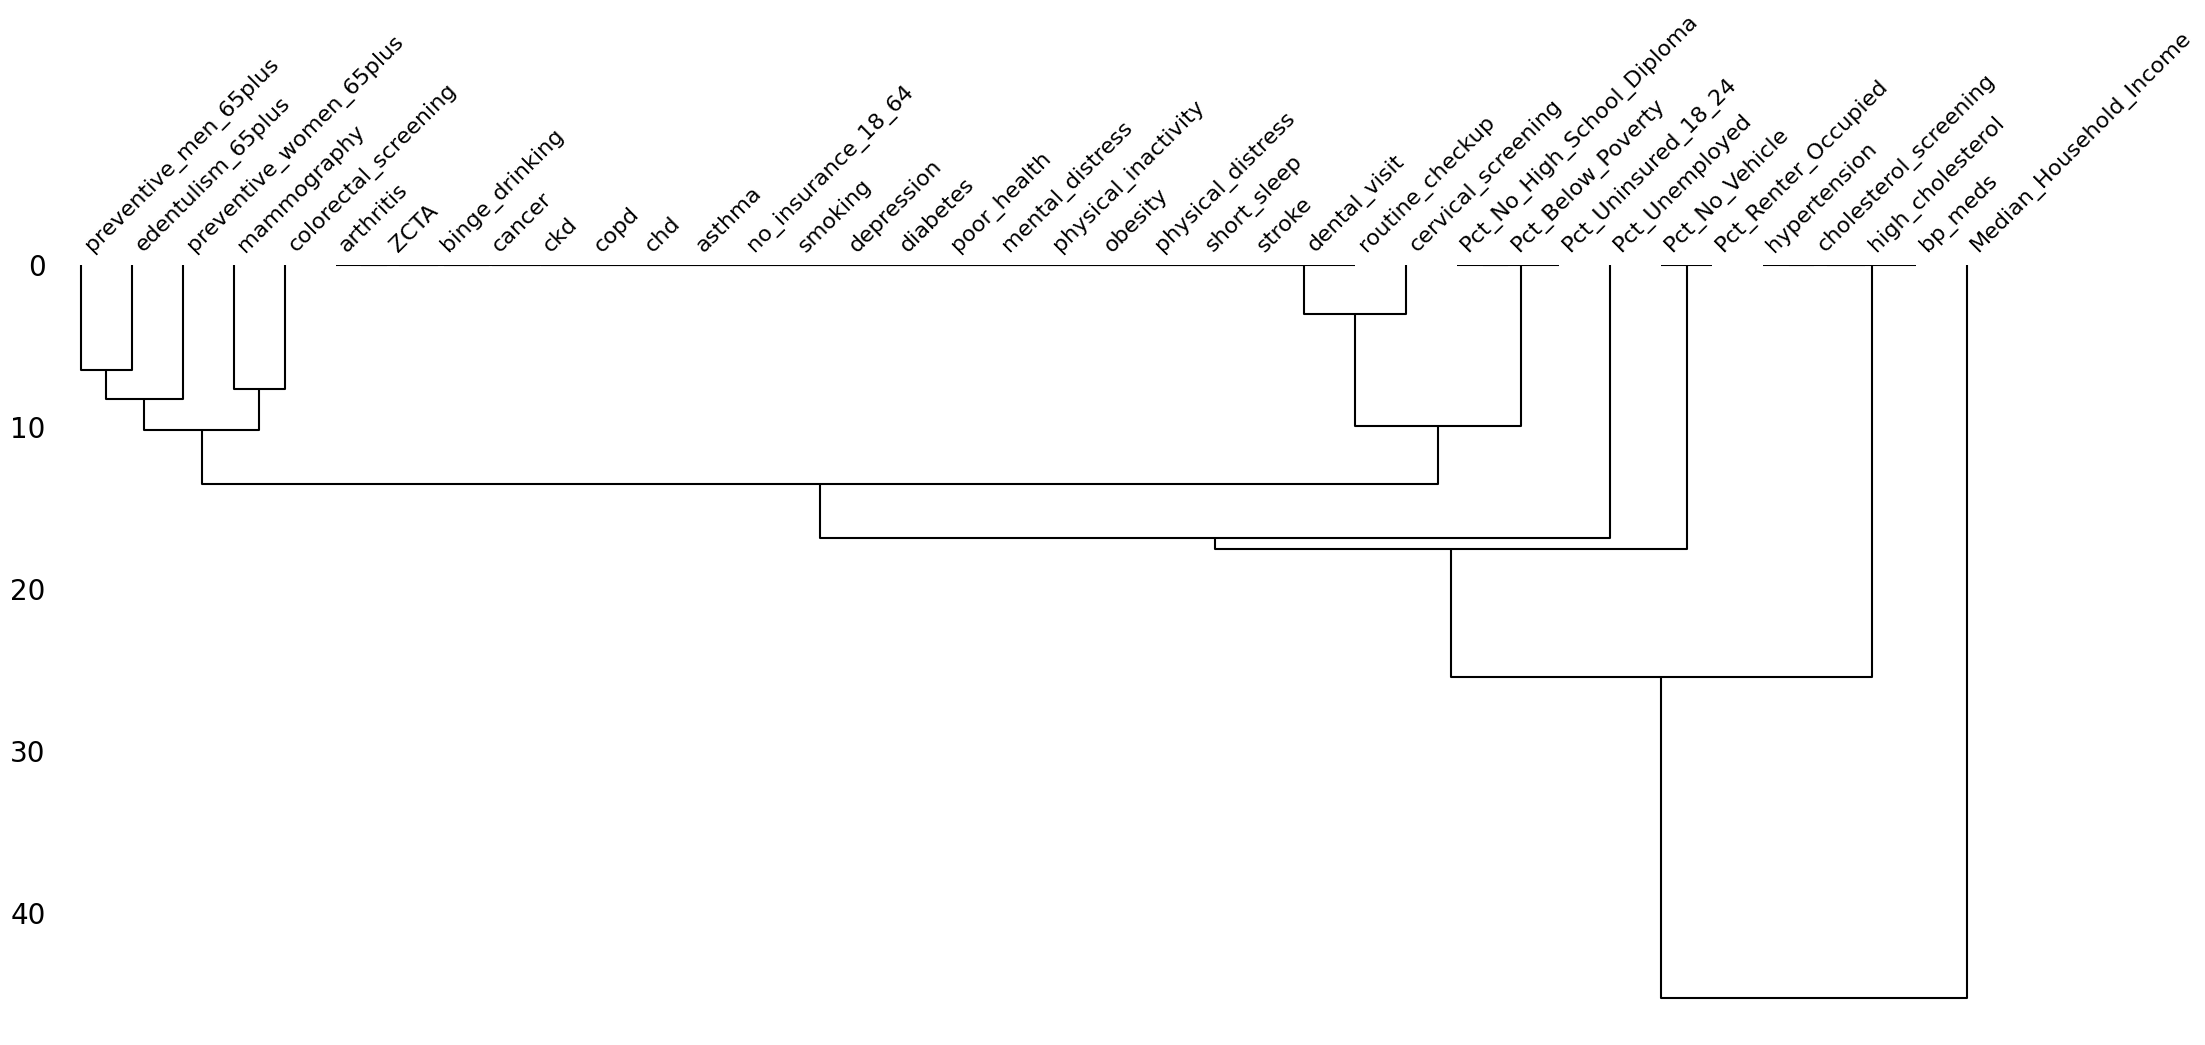

In [25]:
msno.dendrogram(merged_original) 

<span style="font-size:14px"> 

The dendrogram shows the hierarchical clustering of the variables based on their missingness patterns. The closer two variables are in the dendrogram, the more similar their missingness patterns are. 
The dendrogram tells the same story as the heatmap, with Pct_No_High_School_Diploma, Pct_Below_Poverty & Pct_Uninsured_18_24 for instance, clustered together towards the top right.Equally, on the left, we have a cluster of health seeking behavior variables such as cervical cancer screening and other health prevention variables. 

<span style="font-size:14px"> Since we do not have a lot of missing values, we will not proceed with any imputation. We will drop the rows with missing values instead.

In [26]:
place_acs = merged_original.dropna()
glimpse(place_acs, n=3)

,Column,Dtype,% Missing,Min,Max,Mean,Median,Value % (top),Sample (first 3)
0,ZCTA,object,0.0,NaN,NaN,NaN,NaN,"{'85015': 0.0, '17062': 0.0, '29590': 0.0, '93...","[29590, 93306, 93660]"
1,Median_Household_Income,float64,0.0,2499.0,250001.000,62972.355,57578.000,None,"[30985.0, 54450.0, 39625.0]"
2,Pct_Below_Poverty,float64,0.0,0.0,100.000,12.722,10.683,None,"[24.527, 21.338, 25.894]"
3,Pct_Unemployed,float64,0.0,0.0,100.000,5.268,4.313,None,"[4.0, 7.651, 14.851]"
4,Pct_No_High_School_Diploma,float64,0.0,0.0,81.159,7.922,6.591,None,"[17.81, 14.876, 30.402]"
5,Pct_Renter_Occupied,float64,0.0,0.0,100.000,26.179,23.013,None,"[23.225, 36.825, 58.377]"
6,Pct_No_Vehicle,float64,0.0,0.0,100.000,6.086,4.005,None,"[6.795, 4.51, 9.273]"
7,Pct_Uninsured_18_24,float64,0.0,0.0,40.309,1.305,0.589,None,"[0.0, 0.984, 0.955]"
8,edentulism_65plus,float64,0.0,3.3,53.900,15.372,14.600,None,"[24.4, 15.6, 22.6]"
9,arthritis,float64,0.0,3.7,59.200,26.802,27.000,None,"[27.0, 20.9, 19.0]"


<span style="font-size:14px; font-weight:bold;">4.3. Correlation analysis</span>


<span style="font-size:14px"> 
We attempt an imperfect categorization of the variables into potential predictors of health outcomes and health outcomes. Some of the health outcomes such as hypertension and high_cholesterol can also be considered as predictors of other health outcomes such as stroke and chd.

Potential predictors of health outcomes:
Socioeconomic / Demographics
- Median_Household_Income
- Pct_Below_Poverty
- Pct_Unemployed
- Pct_No_High_School_Diploma
- Pct_Renter_Occupied
- Pct_No_Vehicle
- Pct_Uninsured_18_24
- no_insurance_18_64

Behavioral Risk Factors
- smoking
- binge_drinking
- physical_inactivity
- short_sleep

Screenings & Preventive Services
- cervical_screening
- cholesterol_screening
- colorectal_screening
- mammography
- preventive_men_65plus
- preventive_women_65plus
- routine_checkup
- dental_visit
- bp_meds

Health Outcomes
Chronic Disease & Conditions
- diabetes
- hypertension
- high_cholesterol
- obesity
- copd
- chd
- ckd
- cancer
- asthma
- stroke
- arthritis
Functional / Quality of Life
- poor_health
- mental_distress
- physical_distress
- edentulism_65plus

<span style="font-size:14px"> 

Assessing correlation among predictors

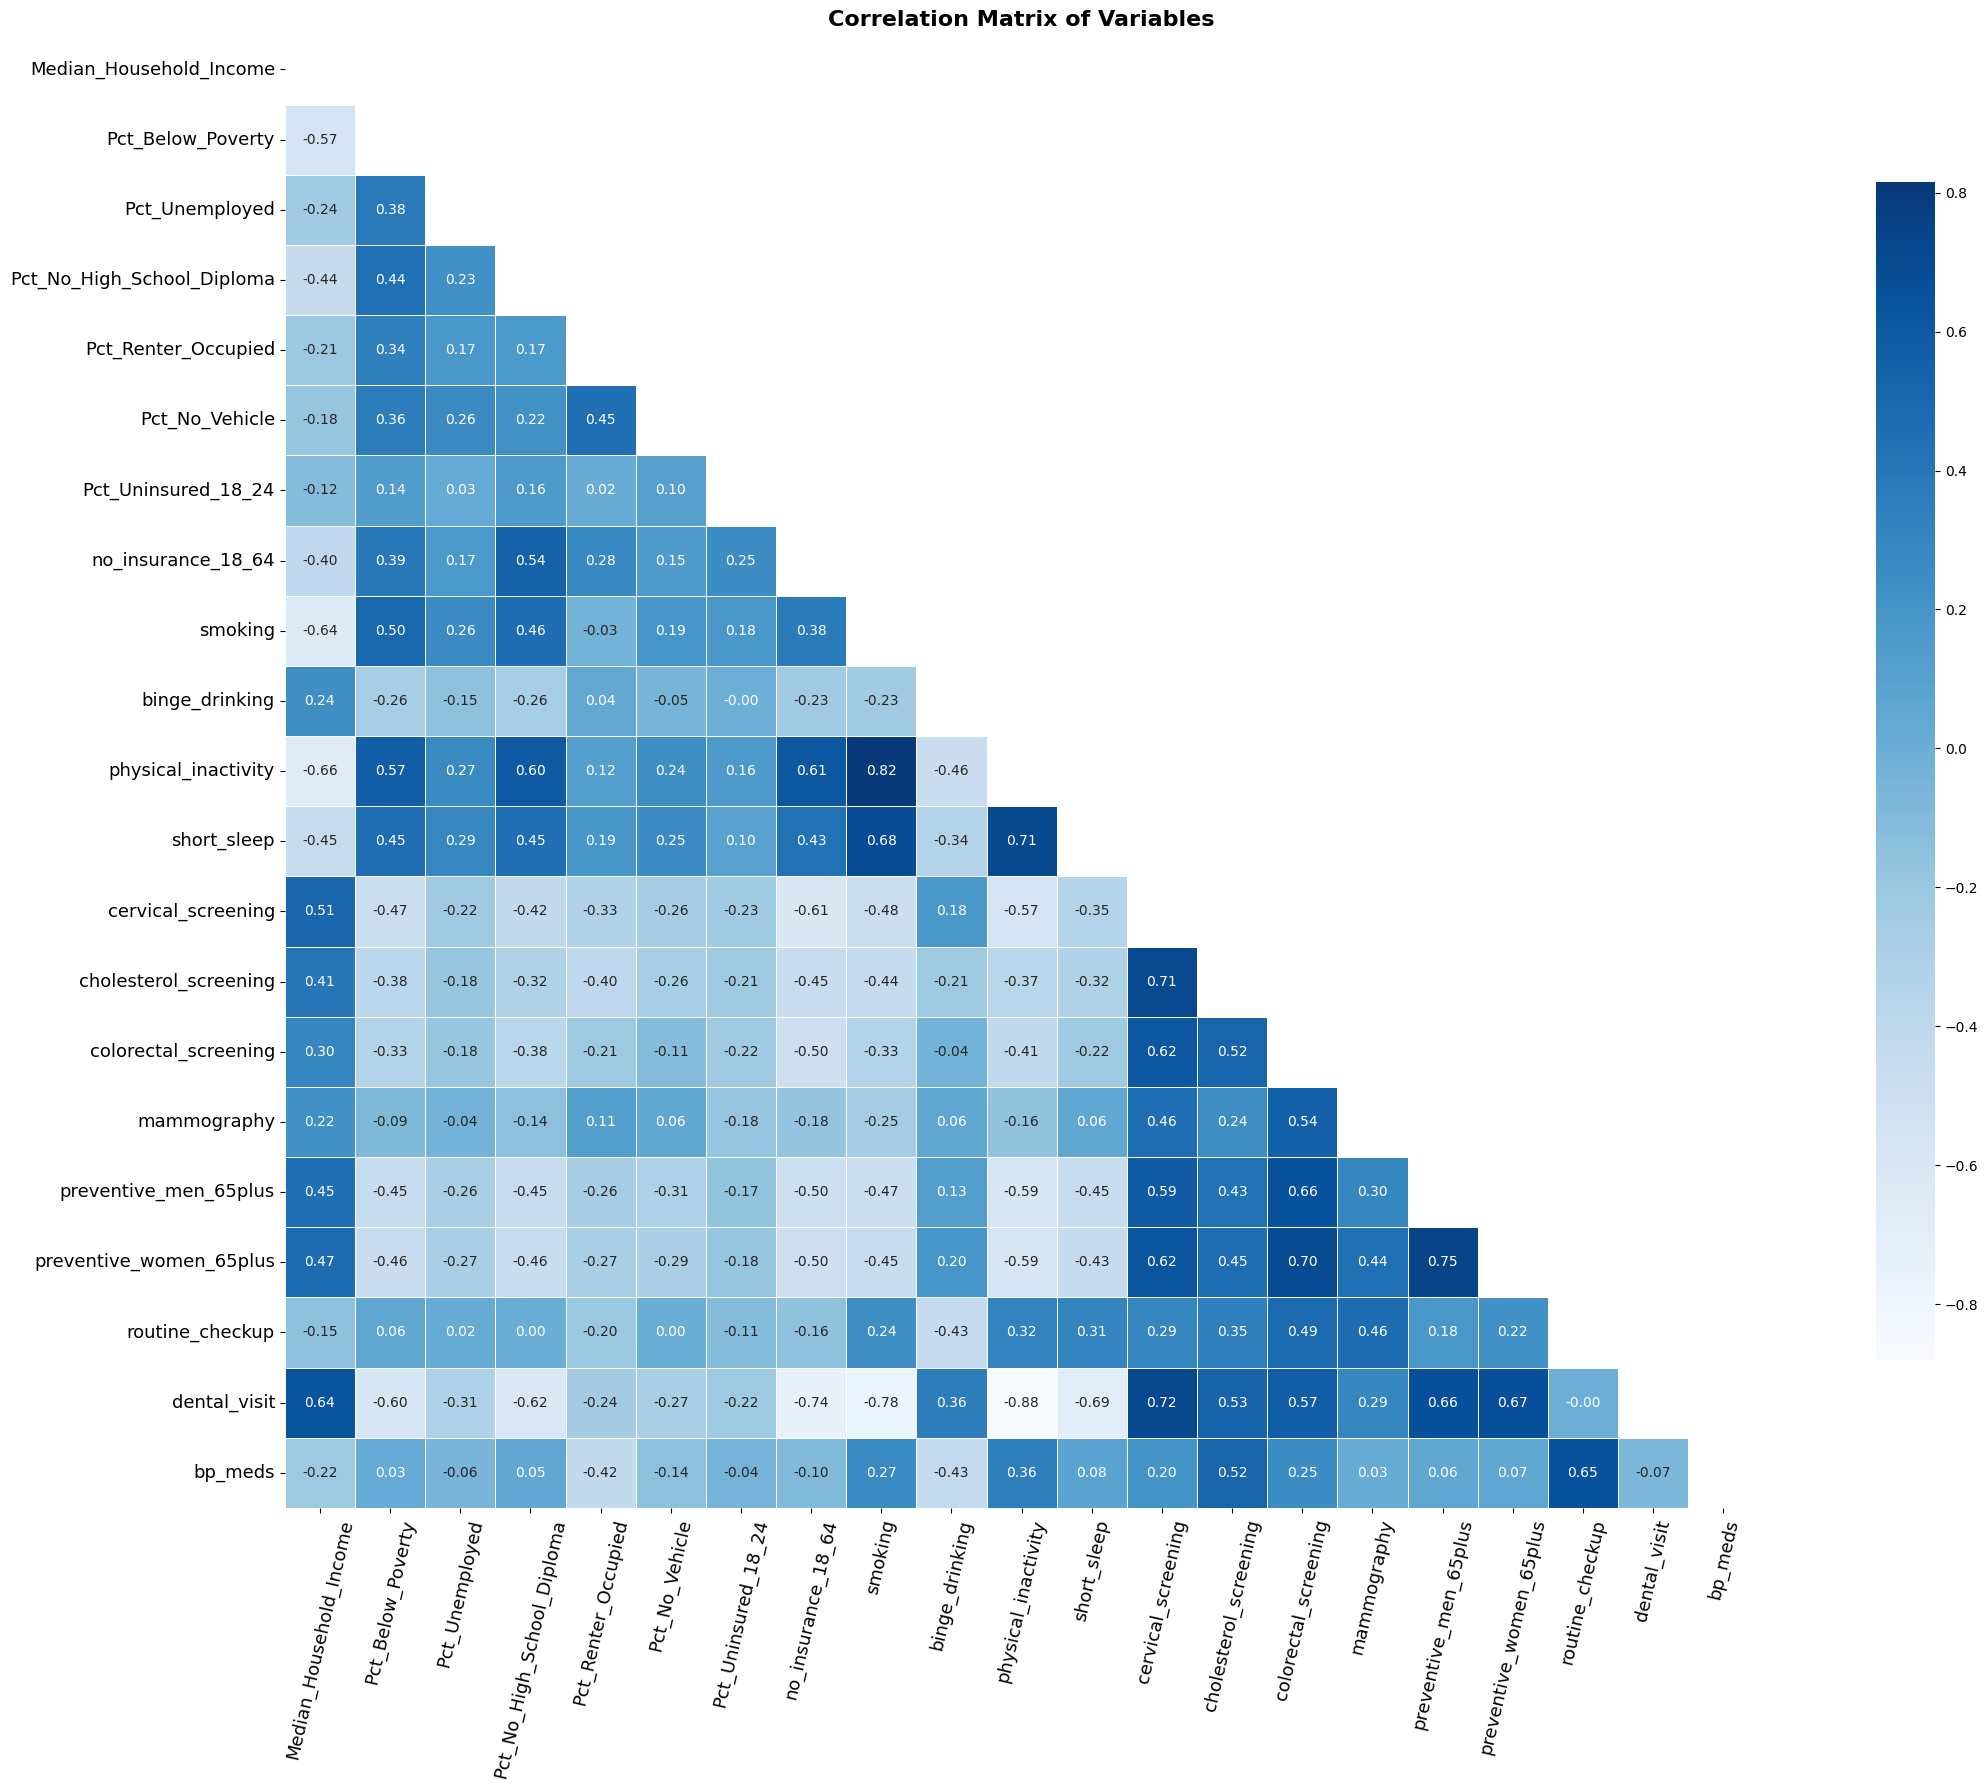

In [27]:
predictors = place_acs[['Median_Household_Income','Pct_Below_Poverty','Pct_Unemployed',
              'Pct_No_High_School_Diploma','Pct_Renter_Occupied',
              'Pct_No_Vehicle','Pct_Uninsured_18_24','no_insurance_18_64',
              'smoking','binge_drinking','physical_inactivity','short_sleep',
              'cervical_screening','cholesterol_screening','colorectal_screening',
              'mammography','preventive_men_65plus','preventive_women_65plus',
              'routine_checkup','dental_visit','bp_meds']]


corr_matrix = predictors.corr(numeric_only=True)

# Create mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(25, 18))  

sns.heatmap(
    corr_matrix,
    mask=mask,             # apply the mask
    annot=True,            # show correlation coefficients
    fmt=".2f",             # format for numbers
    cmap="Blues",       # diverging color palette
    center=0,              # center the colorbar at 0
    square=True,           # square cells
    linewidths=0.5,        # lines between cells
    cbar_kws={"shrink": 0.8}
)
plt.xticks(rotation=77, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.title("Correlation Matrix of Variables", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


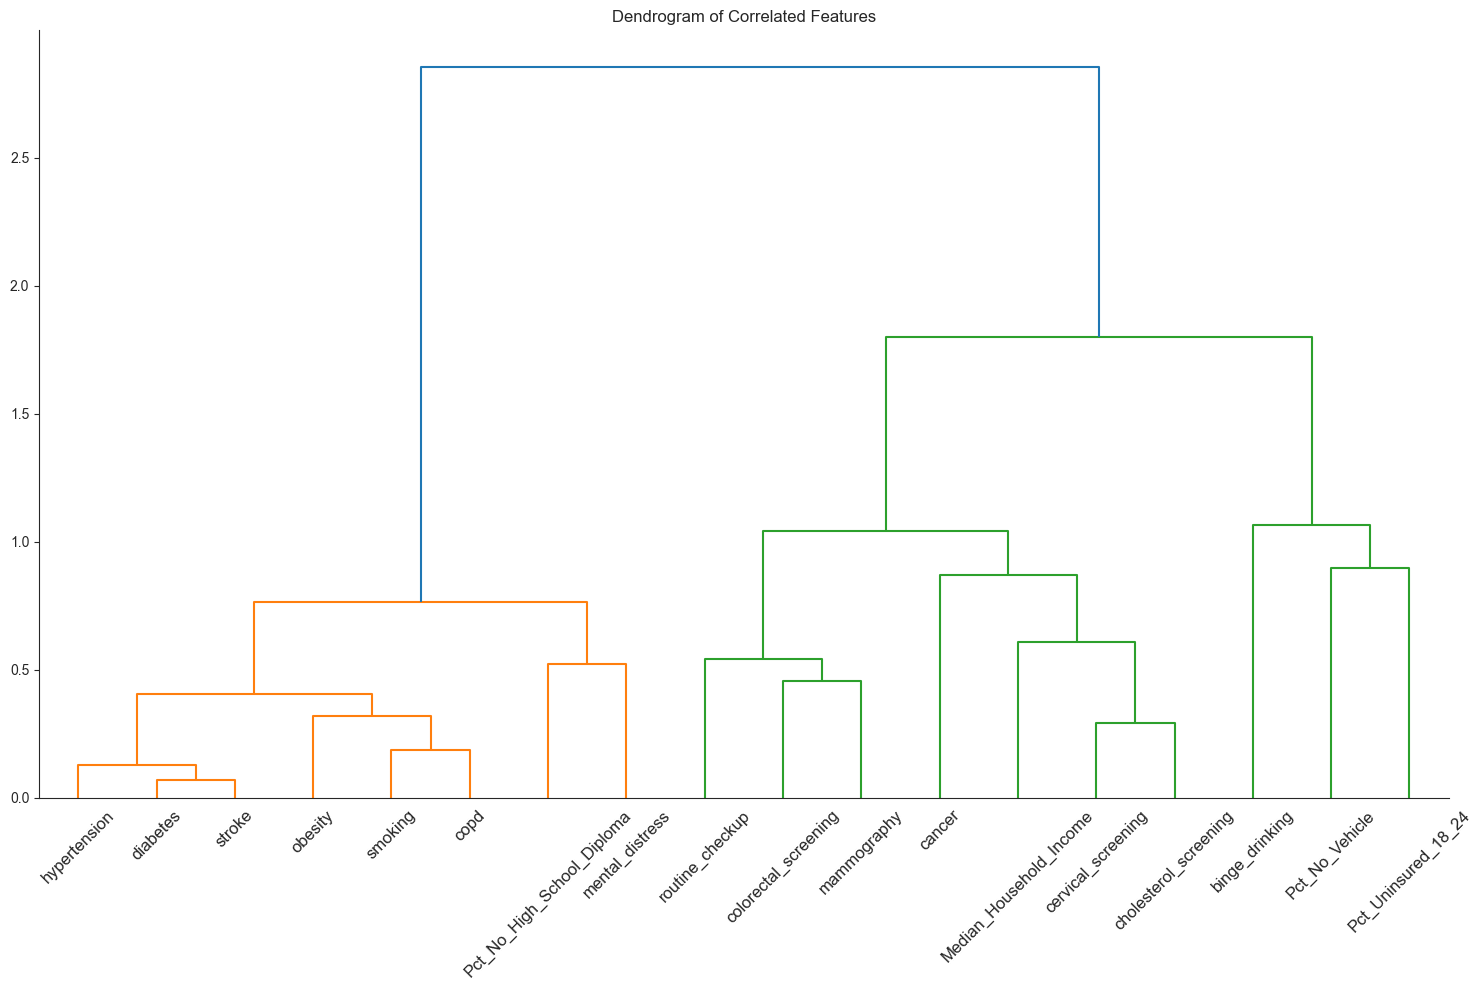

In [46]:
distance_matrix = 1 - corr_matrix
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

fig, ax = plt.subplots(figsize=(15, 10))
dendrogram(linkage_matrix, labels=corr_matrix.columns, leaf_rotation=45)

plt.title("Dendrogram of Correlated Features")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

<span style="font-size:14px"> 
Visually, we can see from the heatmap and the dendrogram, a cluster of health seeking bevarior variables such as cervical cancer screening and cholesterol screening.


<span style="font-size:14px; font-style:italic;">
Remediation Strategies


</span>
<span style="font-size:14px"> 

Various strategies are proposed to address multicollinearity in the dataset:

- Remove Redundant Features: Drop one variable from each highly correlated pair. We can use domain knowledge when choosing which variable to remove.
- Combine Features: Aggregate correlated features using mathematical operations or by averaging them.
- Principal Component Analysis (PCA): Transform correlated variables into uncorrelated principal components, which can reduce dimensionality and address multicollinearity.
- Regularization Techniques: Use models like Ridge Regression or Lasso, which can reduce the impact of multicollinearity by penalizing the coefficients of correlated predictors.
</span>

<span style="font-size:12px"> 
Resources:

- Schreiber-Gregory, D. (2017). Multicollinearity: what is it, why should we care, and how can it be controlled?.
- Sundus, K. I., Hammo, B. H., Al-Zoubi, M. B., & Al-Omari, A. (2022). Solving the multicollinearity problem to improve the stability of machine learning algorithms applied to a fully annotated breast cancer dataset. Informatics in Medicine Unlocked, 33, 101088.

<span style="font-size:14px">

For the purpose of this analysis, we decide to drop the following variables:

- 'Pct_Below_Poverty', 'Pct_Unemployed' and 'Pct_Renter_Occupied', as median household income can serve as a better indicator of socioeconomic indicator. 
- 'no_insurance_18_64', and retain 'Pct_Uninsured_18_24' as it is more specific 



<span style="font-size:14px">

Heatmap with selected variables

In [29]:
place_acs = place_acs[[

    # Geographic information   
    'ZCTA', 
    # Socioeconomic predictors 
    'Median_Household_Income', 
    'Pct_No_High_School_Diploma', 
    'Pct_No_Vehicle', 
    'Pct_Uninsured_18_24', 
    
    # Behavioral predictors 
    'smoking',
    'binge_drinking', 
    'routine_checkup', 
    'colorectal_screening',
    'mammography', 
    'cervical_screening',
    'cholesterol_screening',

    # Health outcomes  
    'diabetes', 
    'hypertension', 
    'copd', 
    'cancer', 
    'obesity', 
    'mental_distress', 
    'stroke']
]

Index(['ZCTA', 'Median_Household_Income', 'Pct_No_High_School_Diploma',
       'Pct_No_Vehicle', 'Pct_Uninsured_18_24', 'smoking', 'binge_drinking',
       'routine_checkup', 'colorectal_screening', 'mammography',
       'cervical_screening', 'cholesterol_screening', 'diabetes',
       'hypertension', 'copd', 'cancer', 'obesity', 'mental_distress',
       'stroke'],
      dtype='object')


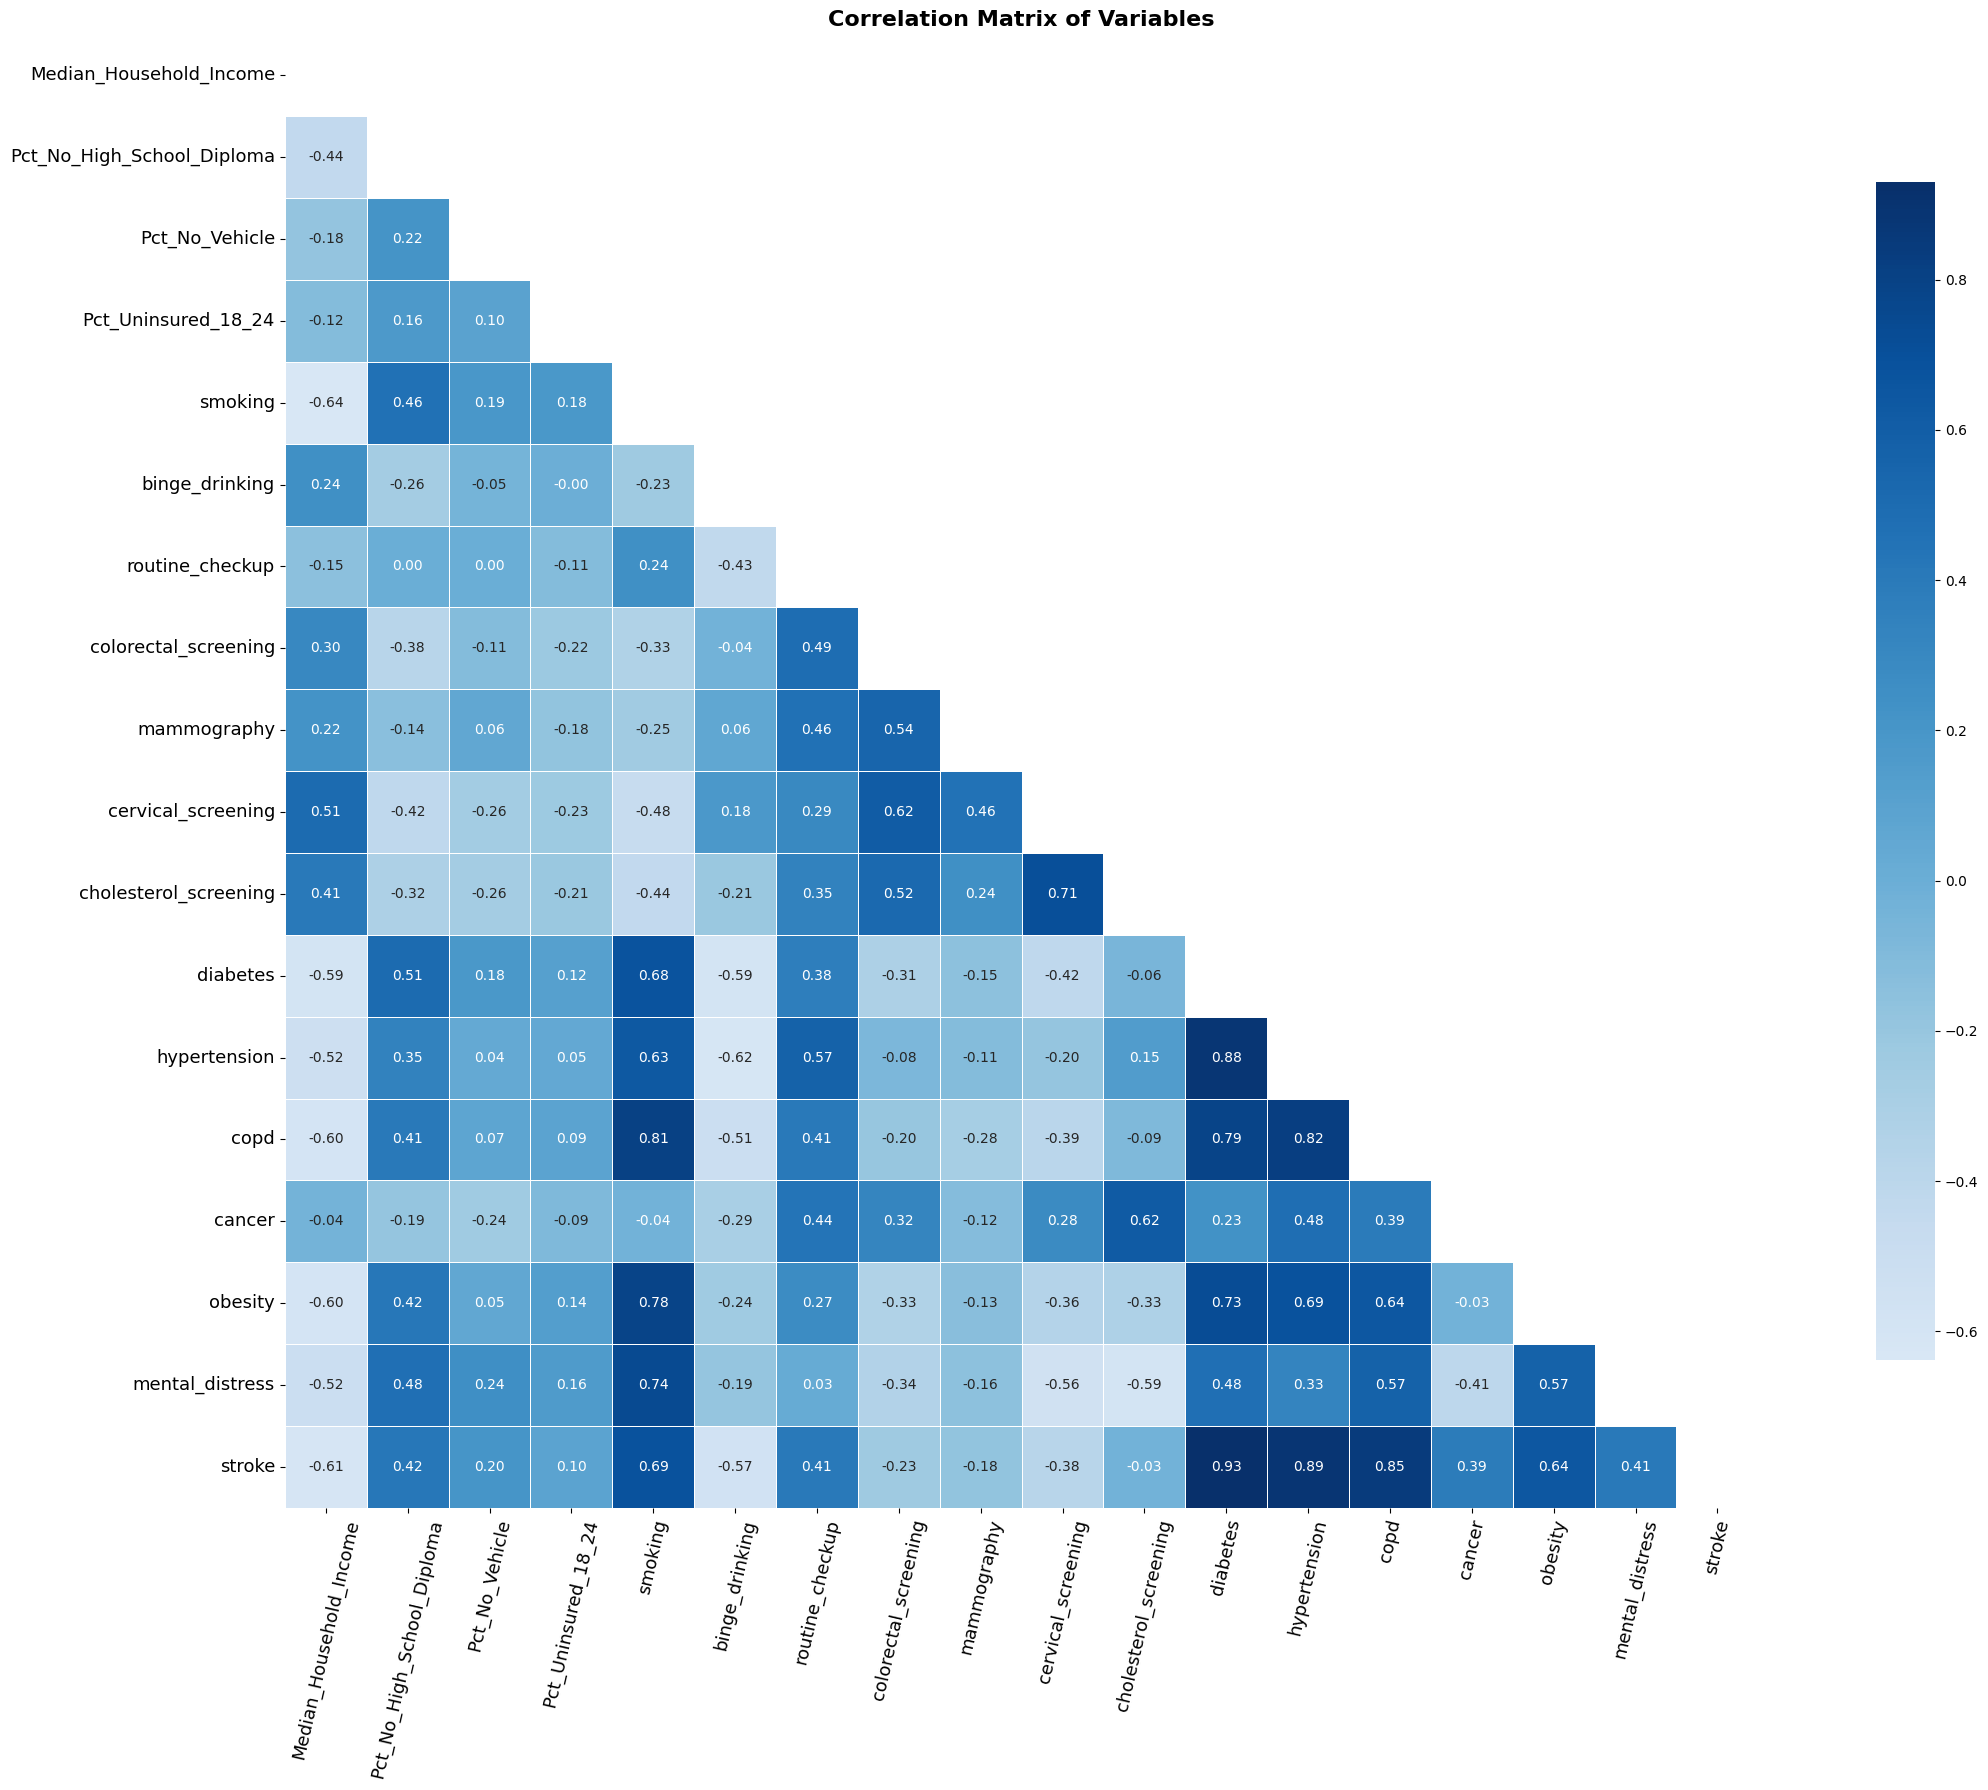

In [30]:
print(place_acs.columns)

corr_matrix = place_acs.corr(numeric_only=True)

# Create mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(25, 18))  

sns.heatmap(
    corr_matrix,
    mask=mask,             # apply the mask
    annot=True,            # show correlation coefficients
    fmt=".2f",             # format for numbers
    cmap="Blues",       # diverging color palette
    center=0,              # center the colorbar at 0
    square=True,           # square cells
    linewidths=0.5,        # lines between cells
    cbar_kws={"shrink": 0.8}
)

plt.xticks(rotation=77, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.title("Correlation Matrix of Variables", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

<span style="font-size:14px"> 
We will assume that median household income is the main predictor of health outcomes and therefore with proceed with a univariate and bivariate analysis using this variable to assess its association with both health outcome and other health seeking behavior

<span style="font-size:14px; font-weight:bold;">4.4. Distribution of variables</span>

In [31]:
place_acs_explore = TableOne(place_acs.drop(columns=['ZCTA']), dip_test=True, normal_test=True, tukey_test=True, show_histograms=True)
place_acs_explore 

Missing            Overall Histogram
n                                                              29743          
Median_Household_Income, mean (SD)              0  62972.4 (26474.6)  ▃█▆▃▂▁▁▁
Pct_No_High_School_Diploma, mean (SD)           0          7.9 (6.0)  ▆█▅▃▂▁▁▁
Pct_No_Vehicle, mean (SD)                       0          6.1 (8.7)  █▃▁▁▁▁▁▁
Pct_Uninsured_18_24, mean (SD)                  0          1.3 (2.4)  █▂▁▁▁▁▁▁
smoking, mean (SD)                              0         19.0 (5.1)  ▂▃▆█▆▄▂▁
binge_drinking, mean (SD)                       0         16.8 (3.1)  ▂▄▆█▆▃▂▁
routine_checkup, mean (SD)                      0         74.5 (4.4)  ▁▂▂▄▆█▄▂
colorectal_screening, mean (SD)                 0         69.0 (5.8)  ▁▁▃▄▇█▅▂
mammography, mean (SD)                          0         74.8 (3.8)  ▁▂▃▅█▅▃▂
cervical_screening, mean (SD)                   0         81.9 (3.3)  ▁▁▂▄▇█▄▂
cholesterol_screening, mean (SD)                0         89.4 (2.8)  ▁▁▁▃▇█▄▂
diabetes, mean (SD)                             0         11.3 (2.9)  ▂▅█▇▄▂▁▁
hypertension, mean (SD)                         0         34.7 (6.3)  ▁▃▅█▆▄▂▁
copd, mean (SD)                                 0          7.8 (2.5)  ▃▅▇█▅▃▂▁
cancer, mean (SD)                               0          6.9 (1.5)  ▁▂▃▆█▃▂▁
obesity, mean (SD)                              0         34.6 (5.7)  ▁▂▃▅█▆▂▁
mental_distress, mean (SD)                      0         15.0 (2.4)  ▂▄▇█▇▄▂▁
stroke, n (%)                         0.4                    4 (0.0)          
                                      0.5                    7 (0.0)          
                                      0.6                    9 (0.0)          
                                      0.7                   18 (0.1)          
                                      0.8                   21 (0.1)          
                                      0.9                   17 (0.1)          
                                      1.0                   26 (0.1)          
                                      1.1                   20 (0.1)          
                                      1.2                   25 (0.1)          
                                      1.3                   46 (0.2)          
                                      1.4                   65 (0.2)          
                                      1.5                   84 (0.3)          
                                      1.6                  123 (0.4)          
                                      1.7                  160 (0.5)          
                                      1.8                  215 (0.7)          
                                      1.9                  328 (1.1)          
                                      2.0                  435 (1.5)          
                                      2.1                  547 (1.8)          
                                      2.2                  635 (2.1)          
                                      2.3                  757 (2.5)          
                                      2.4                  848 (2.9)          
                                      2.5                  963 (3.2)          
                                      2.6                 1013 (3.4)          
                                      2.7                 1092 (3.7)          
                                      2.8                 1192 (4.0)          
                                      2.9                 1299 (4.4)          
                                      3.0                 1294 (4.4)          
                                      3.1                 1360 (4.6)          
                                      3.2                 1341 (4.5)          
                                      3.3                 1442 (4.8)          
                                      3.4                 1383 (4.6)          
                                      3.5                 1304 (4.4)          
             

<span style="font-size:14px">Most variables are multimodal, not normally distributed, and have outliers

<span style="font-size:14px">

- Exploring the multimodality shown by the Hartigan's Dip Test

In [32]:
# Let's create a function to plot KDEs for a list of variables from our dataframe

def plot_kde_vars(data, kde_vars, xlim=(-10, 110), title="KDE of selected variables"):
    ax = data[kde_vars].dropna().plot.kde(figsize=(12, 6))
    
    ax.legend(kde_vars, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(xlim)
    ax.set_title(title)
    ax.set_xlabel("Percent / Prevalence")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


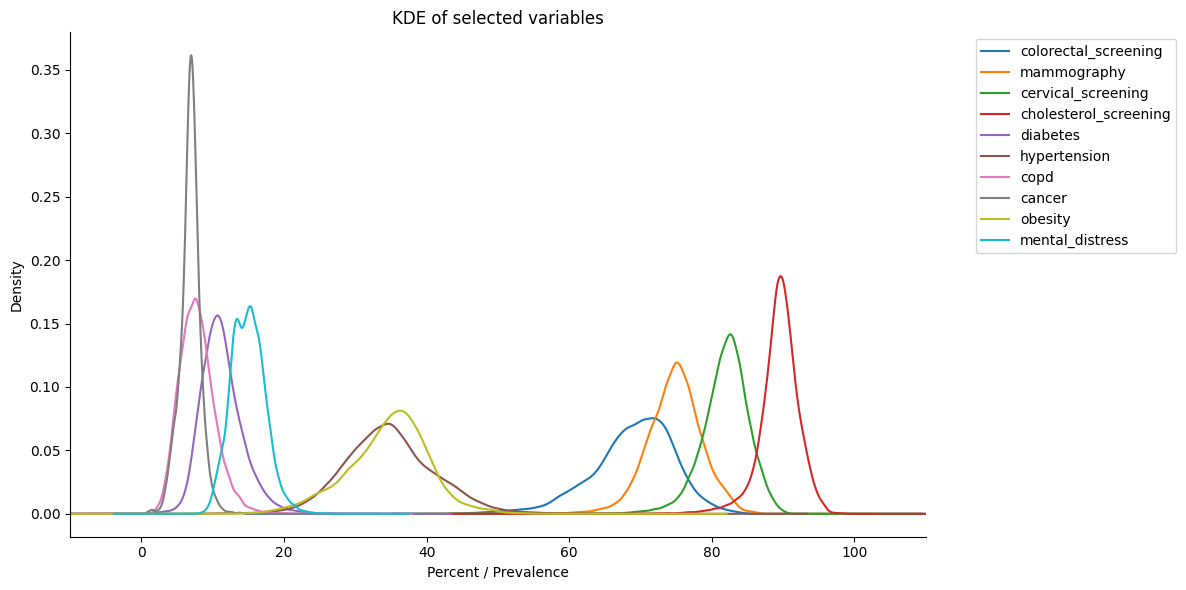

In [33]:
# List 1
list_1 = [
    'colorectal_screening',
    'mammography', 'cervical_screening', 'cholesterol_screening',
    'diabetes', 'hypertension', 'copd', 'cancer', 'obesity', 'mental_distress'
]

plot_kde_vars(place_acs, kde_vars=list_1)

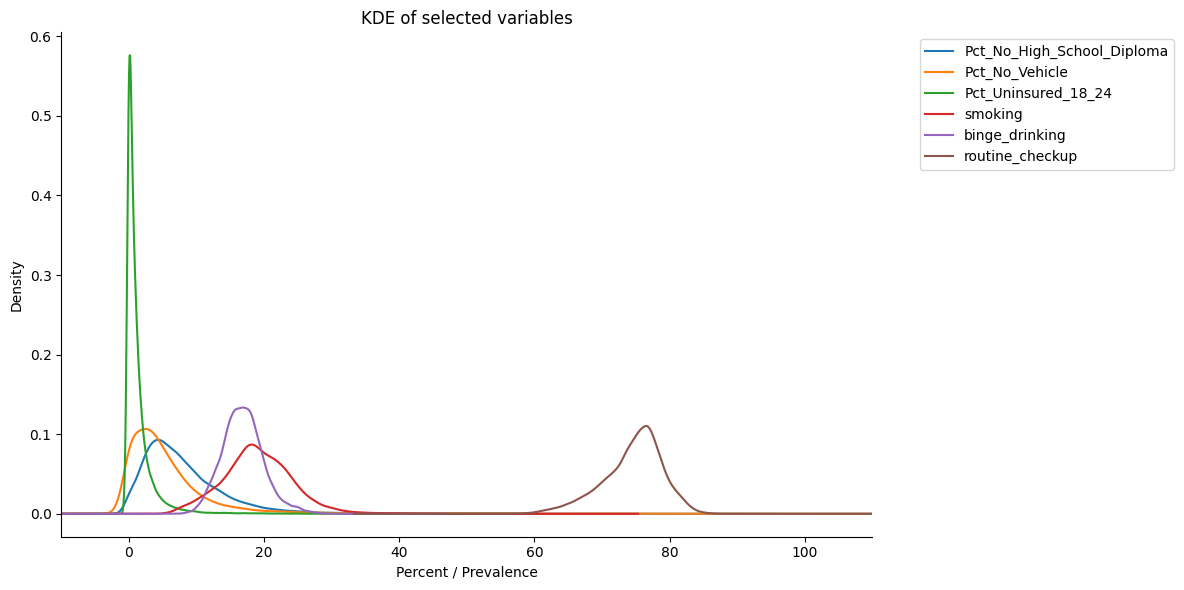

In [34]:
# List 2
list_2 = ['Pct_No_High_School_Diploma', 'Pct_No_Vehicle', 'Pct_Uninsured_18_24',
    'smoking', 'binge_drinking', 'routine_checkup']

plot_kde_vars(place_acs, kde_vars=list_2)


<span style="font-size:14px"> The violation is obvious for some variables such as mental distress, and possibly hypertension

<span style="font-size:14px">

- Exploring the outliers 

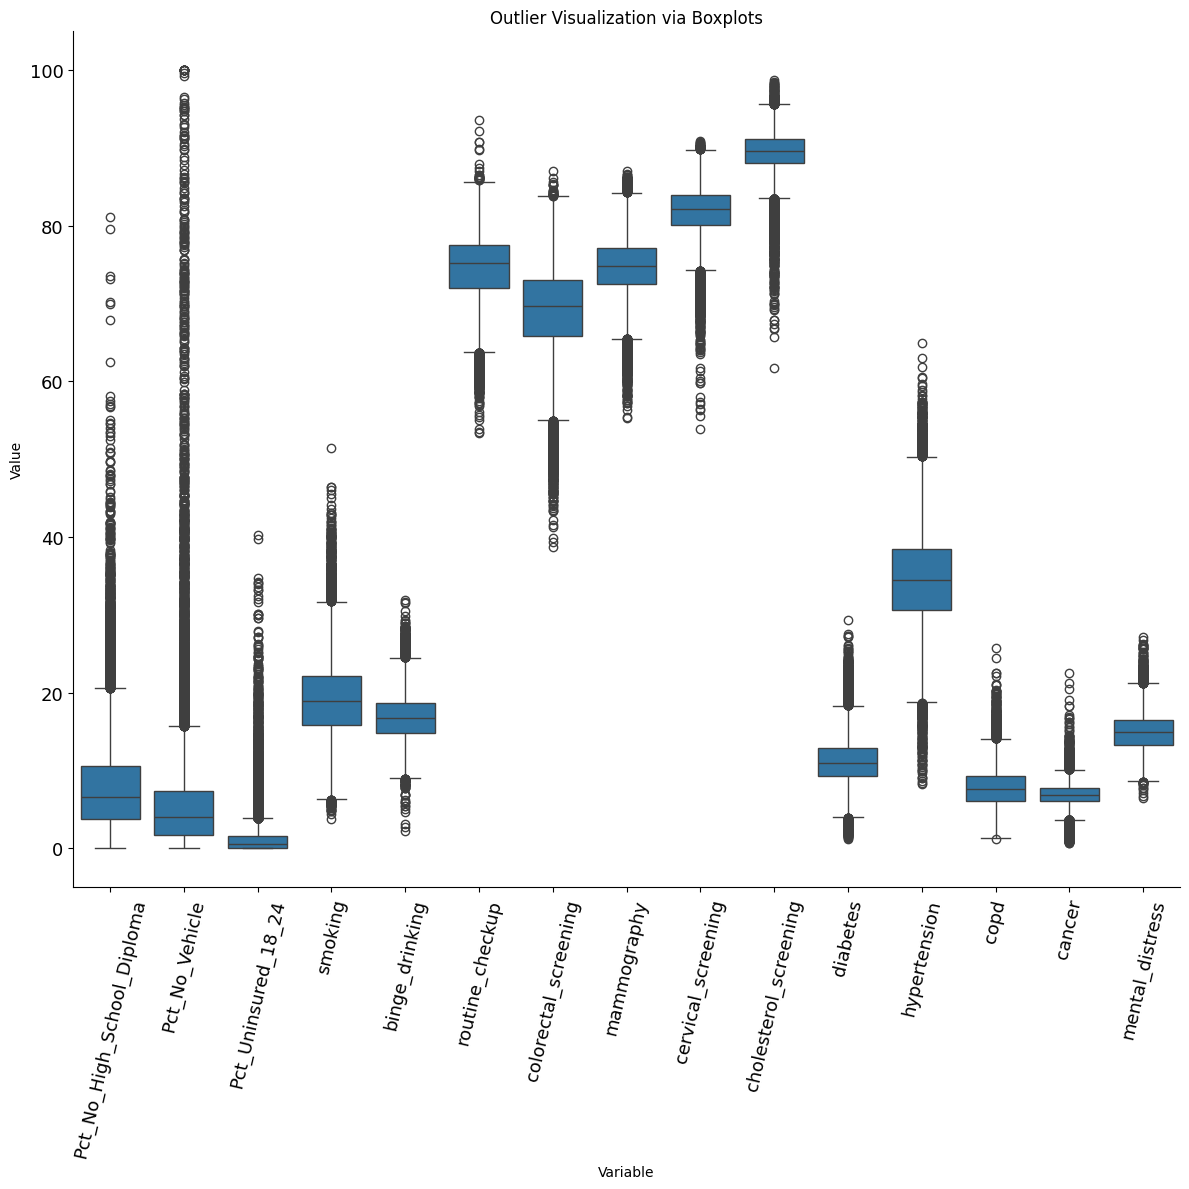

In [35]:
# we did not include Median household income because of the difference in scale
outlier_vars = [
     'Pct_No_High_School_Diploma', 'Pct_No_Vehicle', 'Pct_Uninsured_18_24',
    'smoking', 'binge_drinking', 'routine_checkup', 'colorectal_screening',
    'mammography', 'cervical_screening', 'cholesterol_screening',
    'diabetes', 'hypertension', 'copd', 'cancer', 'mental_distress'
]
long_df = place_acs[outlier_vars].melt(var_name='Variable', value_name='Value')
plt.figure(figsize=(12, 12))
sns.boxplot(x='Variable', y='Value', data=long_df)
plt.xticks(rotation=90)
plt.title("Outlier Visualization via Boxplots")

plt.xticks(rotation=77, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()


<span style="font-size:14px">  Most variables do indeed have multiple outliers

<span style="font-size:14px; font-weight:bold;">4.5. Median houshold income as a categorical variable</span>


<span style="font-size:14px">  We will create a categorical variable based on https://www.pewresearch.org/short-reads/2024/09/16/are-you-in-the-american-middle-class/

In [36]:
# Define bins and labels
bins = [0, 56600, 169800, float("inf")]
labels = ["Low", "Middle", "High"]

# Categorize Median Household Income
place_acs["MHI_cat"] = pd.cut(
    place_acs["Median_Household_Income"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Quick check
print(place_acs[["Median_Household_Income", "MHI_cat"]].head())
print(place_acs["MHI_cat"].value_counts())

# Checking the distribution of the new categorical variable
place_acs["MHI_cat"].value_counts()


   Median_Household_Income MHI_cat
0                  30985.0     Low
1                  54450.0     Low
2                  39625.0     Low
3                  93264.0  Middle
4                  42983.0     Low
MHI_cat
Middle    15320
Low       14222
High        201
Name: count, dtype: int64


MHI_cat
Middle    15320
Low       14222
High        201
Name: count, dtype: int64

In [37]:
glimpse(place_acs, n=3)

,Column,Dtype,% Missing,Min,Max,Mean,Median,Value % (top),Sample (first 3)
0,ZCTA,object,0.0,NaN,NaN,NaN,NaN,"{'85015': 0.0, '17062': 0.0, '29590': 0.0, '93...","[29590, 93306, 93660]"
1,Median_Household_Income,float64,0.0,2499.0,250001.000,62972.355,57578.000,None,"[30985.0, 54450.0, 39625.0]"
2,Pct_No_High_School_Diploma,float64,0.0,0.0,81.159,7.922,6.591,None,"[17.81, 14.876, 30.402]"
3,Pct_No_Vehicle,float64,0.0,0.0,100.000,6.086,4.005,None,"[6.795, 4.51, 9.273]"
4,Pct_Uninsured_18_24,float64,0.0,0.0,40.309,1.305,0.589,None,"[0.0, 0.984, 0.955]"
5,smoking,float64,0.0,3.8,51.500,19.045,18.900,None,"[24.7, 15.2, 18.3]"
6,binge_drinking,float64,0.0,2.2,31.900,16.848,16.700,None,"[16.1, 17.0, 17.7]"
7,routine_checkup,float64,0.0,53.4,93.600,74.542,75.200,None,"[79.8, 67.7, 62.4]"
8,colorectal_screening,float64,0.0,38.7,87.000,69.017,69.700,None,"[72.6, 59.5, 45.9]"
9,mammography,float64,0.0,55.3,87.100,74.791,74.900,None,"[82.6, 72.6, 70.3]"


<span style="font-size:14px; font-weight:bold;">4.6. Univariate analysis of Median household income</span>


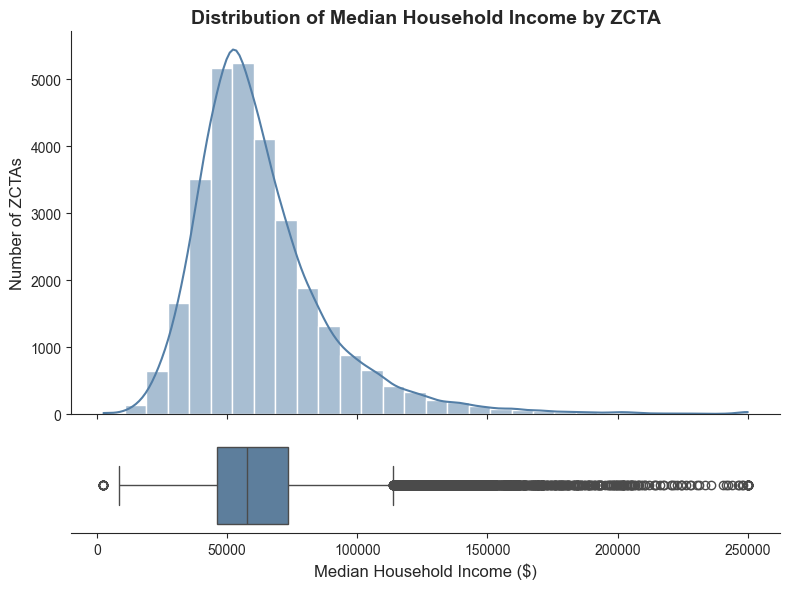

In [38]:
sns.set_style("ticks")

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, sharex=True, 
    gridspec_kw={"height_ratios": [4, 1]}, figsize=(8,6)
)

# Histogram
sns.histplot(
    data=place_acs,
    x="Median_Household_Income",
    bins=30, kde=True,
    color="#537EA6", edgecolor=None,
    ax=ax1
)
ax1.set_title("Distribution of Median Household Income by ZCTA", fontsize=14, weight="bold")
ax1.set_ylabel("Number of ZCTAs", fontsize=12)

# Boxplot (horizontal, same x-axis)
sns.boxplot(
    data=place_acs,
    x="Median_Household_Income",
    color="#537EA6", ax=ax2
)
ax2.set_xlabel("Median Household Income ($)", fontsize=12)
ax2.set_yticks([])  # hide y-axis on boxplot

sns.despine(ax=ax1)
sns.despine(ax=ax2, left=True)
plt.tight_layout()
plt.show()


<span style="font-size:14px">
As expected, the median household income, even at the ZCTA level, is still skewed to the right.

<span style="font-size:14px; font-weight:bold;">4.7. Bivariate analysis of Median household income</span>


<span style="font-size:14px">

- Exploring the relationship between median household income and health outcomes

<span style="font-size:14px; font-style=italic;">
Let's generate a function to plot variables against median household income, both as a continuous variable and as a categorical variable
</span>

In [39]:
def plot_vars_vs_income(data, vars, income_col="Median_Household_Income", income_cat_col="MHI_cat"):
    n = len(vars)
    ncols = 2
    nrows = n

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))

    # Handle case when n == 1
    if n == 1:
        axes = axes.reshape(1, 2)

    for i, var in enumerate(vars):
        # Left: regression plot
        sns.regplot(
            data=data,
            x=income_col,
            y=var,
            ci=None,
            line_kws={"color": "red"},
            ax=axes[i, 0]
        )
        axes[i, 0].set_title(f"{var.replace('_', ' ').capitalize()} vs {income_col.replace('_',' ')}",
                             fontsize=12, weight="bold")
        axes[i, 0].set_xlabel(income_col.replace('_', ' '))
        axes[i, 0].set_ylabel(f"{var.replace('_', ' ').capitalize()} crude prevalence")

        # Right: boxplot
        sns.boxplot(
            data=data,
            x=income_cat_col,
            y=var,
            ax=axes[i, 1]
        )
        axes[i, 1].set_title(f"{var.replace('_', ' ').capitalize()} vs {income_cat_col.replace('_',' ')}",
                             fontsize=12, weight="bold")
        axes[i, 1].set_xlabel(income_cat_col.replace('_', ' '))
        axes[i, 1].set_ylabel(f"{var.replace('_', ' ').capitalize()} crude prevalence")

    plt.tight_layout()
    plt.show()


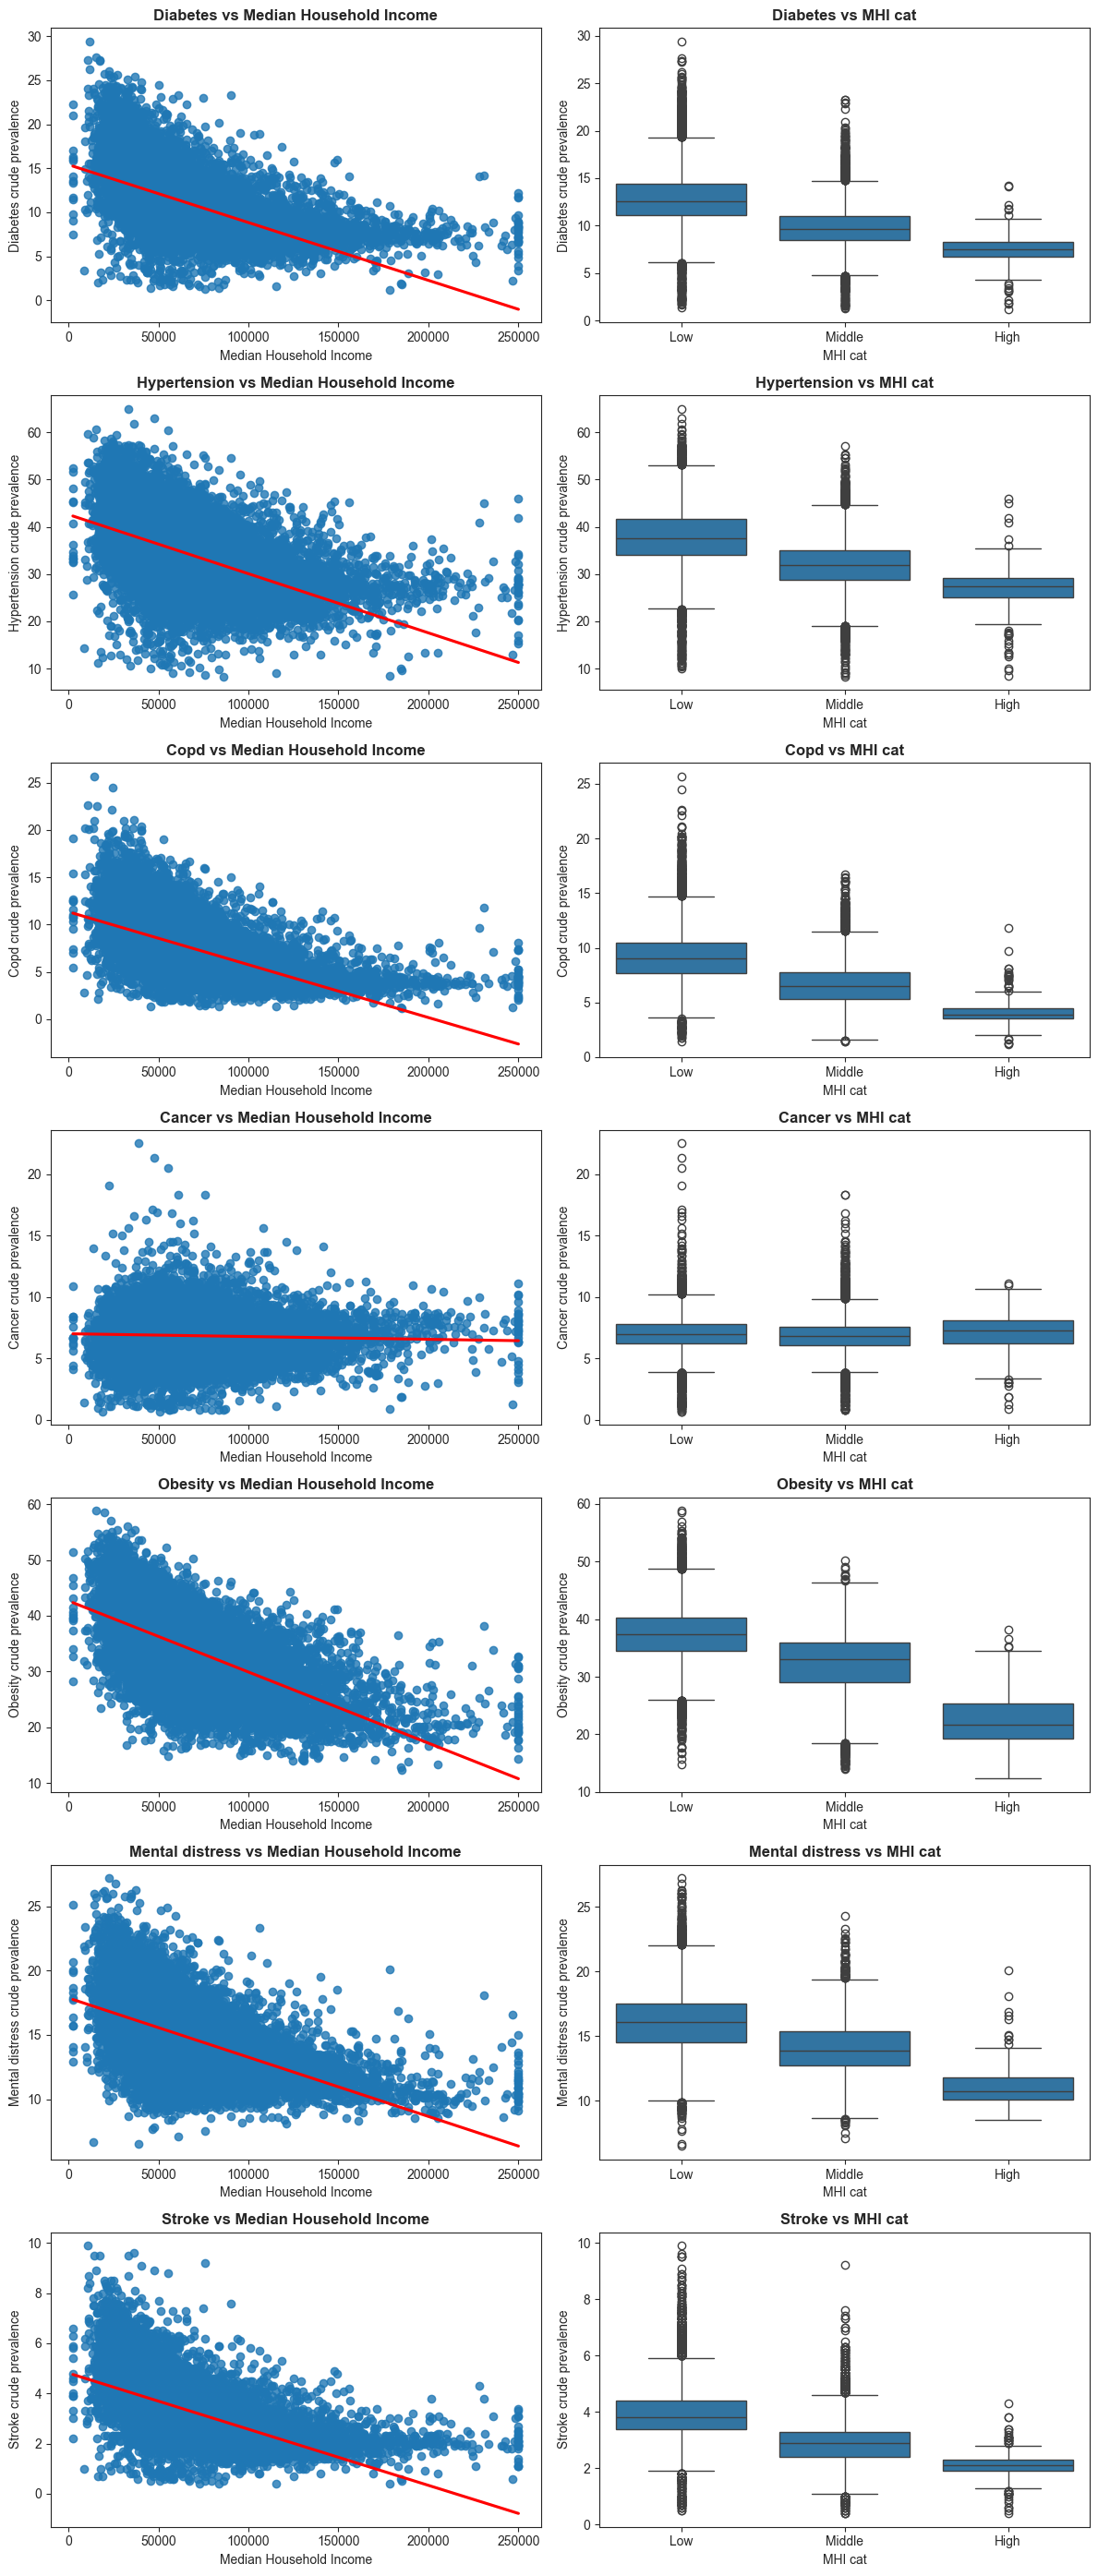

In [40]:
outcomes = ["diabetes", "hypertension", "copd","cancer","obesity","mental_distress","stroke"]

plot_vars_vs_income(place_acs, vars = outcomes)

__Summary:__

<span style="font-size:14px; font-style:italic">
 Except for cancer, the crude prevalence of all health outcome seems to decrease as the median household income increases.
</span>

<span style="font-size:14px">

- Exploring the relationship between median household income and other predictors

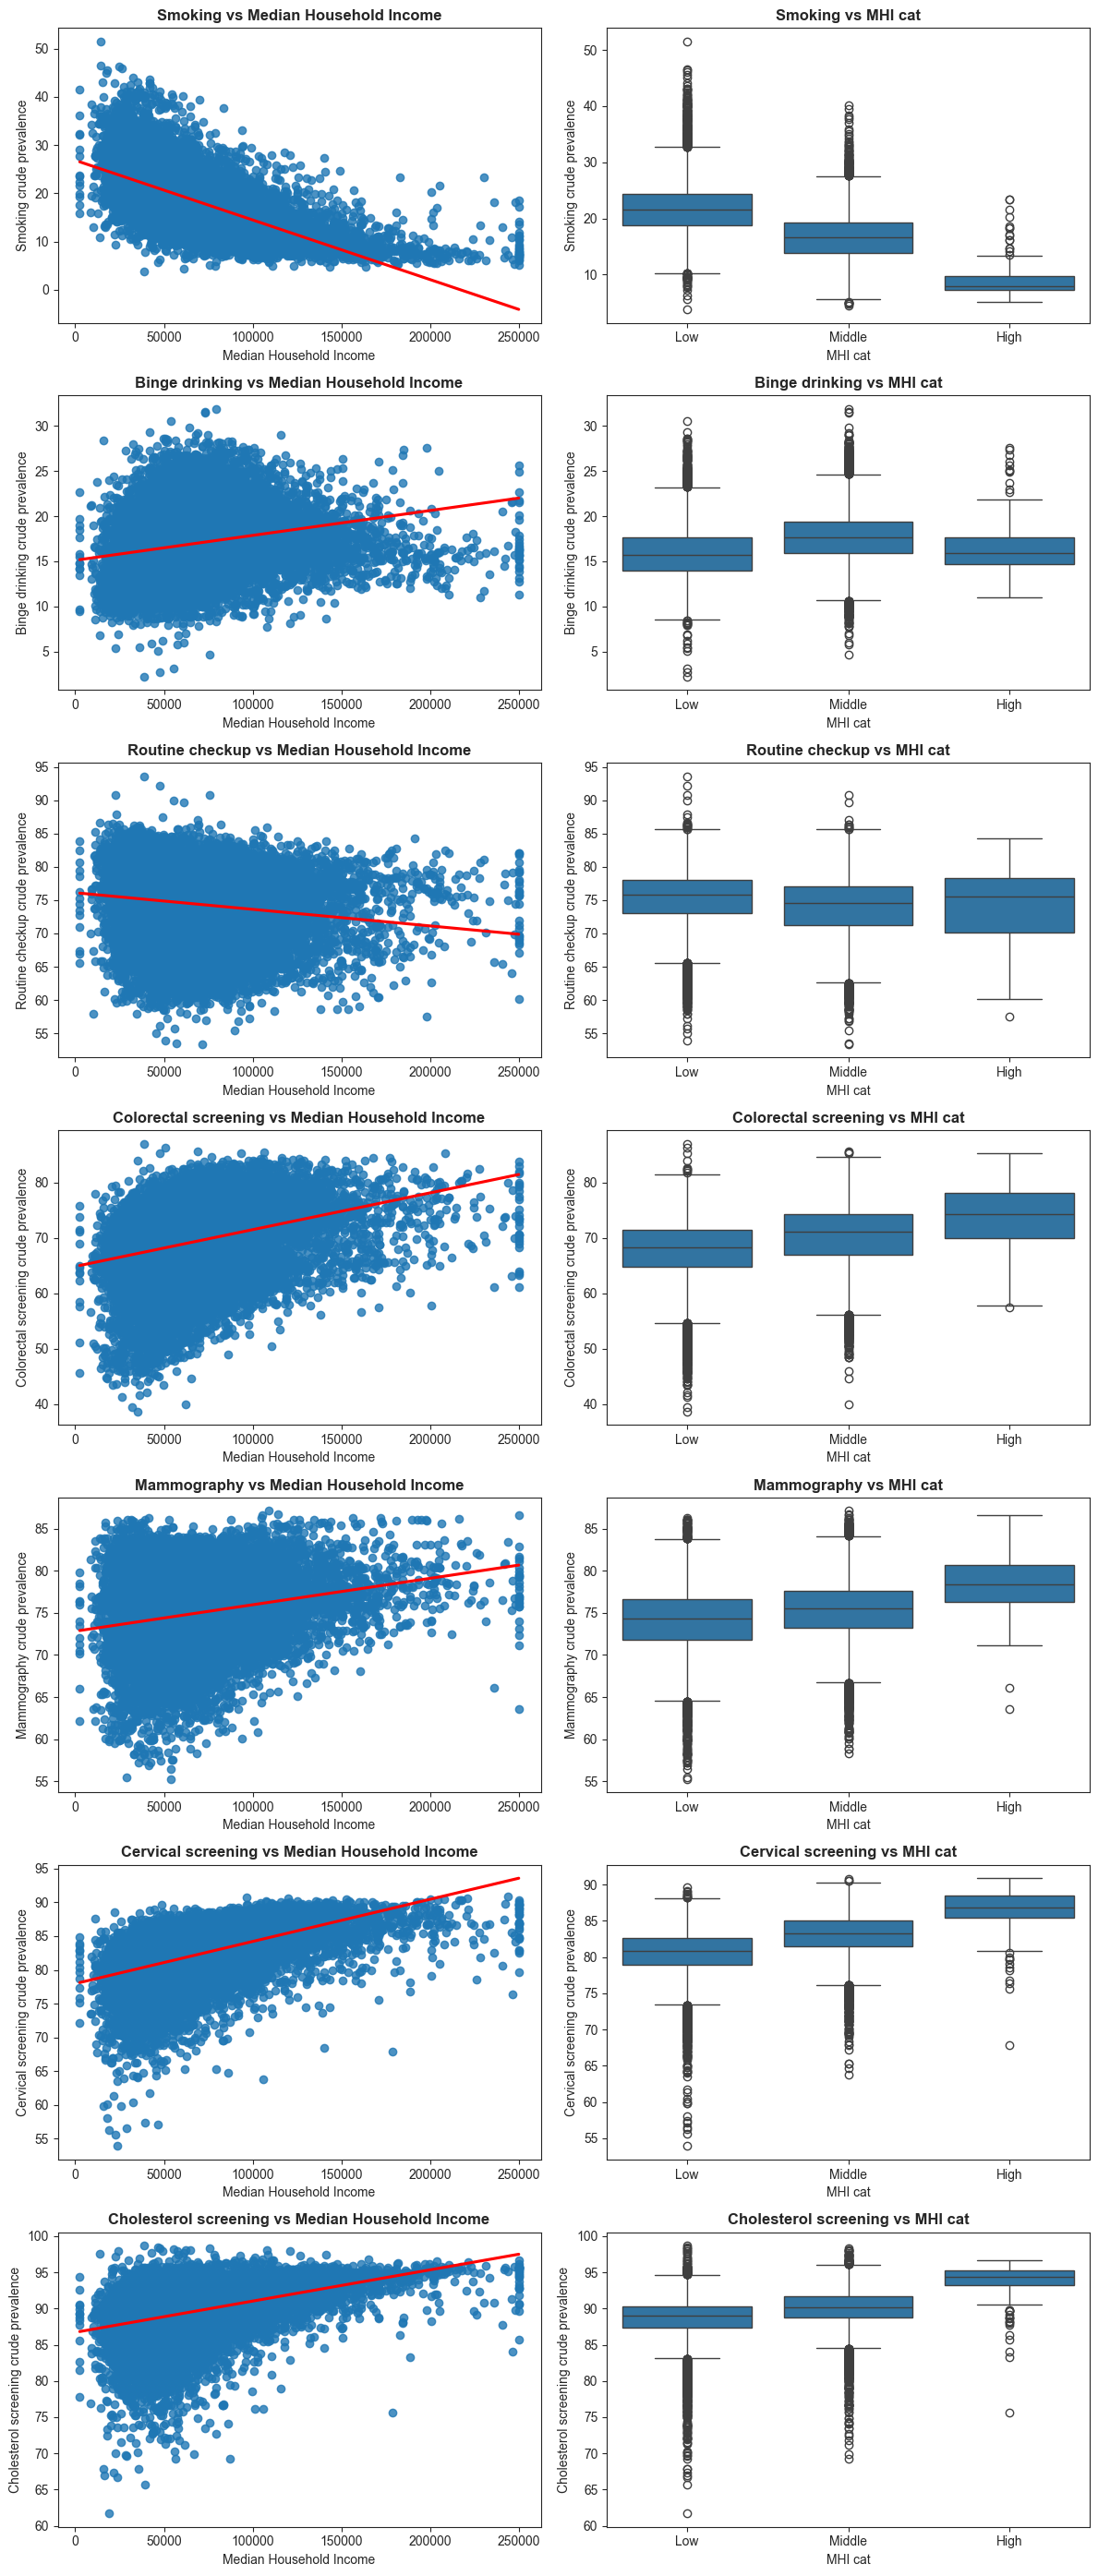

In [41]:
behaviors = ["smoking", "binge_drinking", "routine_checkup", "colorectal_screening", "mammography","cervical_screening",
    "cholesterol_screening"]

plot_vars_vs_income(place_acs, vars = behaviors)


__Summary:__

<span style="font-size:14px; font-style:italic">
 The crude prevalence of most screening behavior (cholesterol, cervical cancer, mammography, colorectal cancer) seems to increase as the median household income increases. While smoking tends to decrease, binge drinking seems to increase with median household income.
</span>

<span style="font-size:14px; font-weight:bold;">4.7. Summary statistics</span>


<span style="font-size:14px; font-style:italic;">
Let's create a function to generate a summary table, stratified by median household income brackets.
</span>


In [42]:
def format_pvalue(p):
    """Format p-values for readability."""
    if pd.isna(p):
        return ""
    elif p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

def create_table_one(
    df,
    group_col,
    continuous_vars=None,
    categorical_vars=None,
    ordered_groups=None,
    rename_map=None
):
    """
    Create a polished Table 1 summary.
    """
    continuous_vars = continuous_vars or []
    categorical_vars = categorical_vars or []
    rename_map = rename_map or {}

    # Ensure group column is ordered
    if ordered_groups:
        df[group_col] = pd.Categorical(df[group_col], categories=ordered_groups, ordered=True)
        groups = ordered_groups
    else:
        groups = df[group_col].dropna().unique().tolist()

    results = []

    # Continuous variables
    for var in continuous_vars:
        var_name = rename_map.get(var, var)

        row_mean = {"Variable": var_name}
        row_median = {"Variable": ""}

        samples = []

        for g in groups:
            vals = df.loc[df[group_col] == g, var].dropna()
            samples.append(vals)

            mean = vals.mean()
            std = vals.std()
            median = vals.median()
            q1, q3 = np.percentile(vals, [25, 75])

            row_mean[g] = f"{mean:.1f} ± {std:.1f}"
            row_median[g] = f"({median:.1f} [{q1:.1f}, {q3:.1f}])"

        pval = np.nan
        if len(samples) > 1:
            _, pval = kruskal(*samples)

        row_mean["P-Value"] = format_pvalue(pval)
        row_median["P-Value"] = ""

        results.append(row_mean)
        results.append(row_median)

    # Categorical variables
    for var in categorical_vars:
        var_name = rename_map.get(var, var)
        row = {"Variable": var_name}

        table = pd.crosstab(df[var], df[group_col])
        for g in groups:
            if g not in table.columns:
                table[g] = 0
        table = table[groups]

        chi2, pval, _, _ = chi2_contingency(table)

        for g in groups:
            subset = df[df[group_col] == g]
            counts = subset[var].value_counts(dropna=False)
            total = counts.sum()

            summary = []
            for level in counts.index:
                count = counts[level]
                pct = (count / total) * 100 if total > 0 else 0
                summary.append(f"{level}: {count} ({pct:.1f}%)")

            row[g] = " | ".join(summary)

        row["P-Value"] = format_pvalue(pval)
        results.append(row)

    # Final table
    table = pd.DataFrame(results).set_index("Variable")
    cols = list(groups) + ["P-Value"]
    table = table[cols]

    return table

def print_table_one(table):

    # ANSI escape codes for bold
    BOLD = '\033[1m'
    RESET = '\033[0m'

    # Column width calculations
    col_widths = {}
    index_name = "Variable"
    col_widths[index_name] = max(len(index_name), max(len(str(idx)) for idx in table.index))

    for col in table.columns:
        max_val_len = max(len(str(v)) for v in table[col])
        col_widths[col] = max(len(col), max_val_len)

    padding = 3
    total_width = col_widths[index_name] + sum(col_widths.values()) + padding * (len(col_widths) + 1)
    line = "━" * total_width

    # Build header with actual bold text
    header = f"{BOLD}{index_name.ljust(col_widths[index_name])}"
    for col in table.columns:
        header += " " * padding + col.ljust(col_widths[col])
    header += f"{RESET}"

    # Print table
    thin_line = "─" * total_width  # thinner line before header
    print(thin_line)
    print(header)
    print(line)  # thicker line below header

    for idx, row in table.iterrows():
        row_str = str(idx).ljust(col_widths[index_name])
        for col in table.columns:
            row_str += " " * padding + str(row[col]).ljust(col_widths[col])
        print(row_str)

    print(line)

In [43]:
# Listing and renaming variables
rename_map = {
    'Median_Household_Income': 'Median Household Income',
    'Pct_No_High_School_Diploma': 'No High School Diploma (%)',
    'Pct_No_Vehicle': 'No Vehicle (%)',
    'Pct_Uninsured_18_24': 'Uninsured (Age 18–24) (%)',
    'smoking': 'Smoking (%)',
    'binge_drinking': 'Binge Drinking (%)',
    'routine_checkup': 'Routine Checkup (%)',
    'colorectal_screening': 'Colorectal Screening (%)',
    'mammography': 'Mammography (%)',
    'cervical_screening': 'Cervical Screening (%)',
    'cholesterol_screening': 'Cholesterol Screening (%)',
    'diabetes': 'Diabetes (%)',
    'hypertension': 'Hypertension (%)',
    'copd': 'COPD (%)',
    'cancer': 'Cancer (%)',
    'obesity': 'Obesity (%)',
    'mental_distress': 'Mental Distress (%)',
    'stroke': 'Stroke (%)'
}

# Generate table
table1 = create_table_one(
    df=place_acs,
    group_col="MHI_cat",
    continuous_vars=[
        'Median_Household_Income', 'Pct_No_High_School_Diploma',
        'Pct_No_Vehicle', 'Pct_Uninsured_18_24', 'smoking', 'binge_drinking',
        'routine_checkup', 'colorectal_screening', 'mammography',
        'cervical_screening', 'cholesterol_screening', 'diabetes',
        'hypertension', 'copd', 'cancer', 'obesity', 'mental_distress', 'stroke'
    ],
    categorical_vars=[],  # Add categorical vars if needed
    ordered_groups=["Low", "Middle", "High"],
    rename_map=rename_map
)
table1

,Low,Middle,High,P-Value
Variable,,,,
Median Household Income,44069.6 ± 9056.9,78699.4 ± 21065.6,201760.2 ± 26376.2,<0.001
,"(45744.0 [38616.0, 51339.8])","(72083.0 [63198.8, 87159.0])","(196146.0 [179702.0, 217546.0])",
No High School Diploma (%),10.4 ± 6.5,5.7 ± 4.4,1.8 ± 2.8,<0.001
,"(9.3 [6.2, 13.3])","(4.7 [2.9, 7.3])","(1.2 [0.6, 2.1])",
No Vehicle (%),7.8 ± 9.8,4.5 ± 7.0,5.4 ± 14.4,<0.001
,"(5.7 [2.6, 9.6])","(3.0 [1.4, 5.3])","(1.8 [0.4, 3.7])",
Uninsured (Age 18–24) (%),1.5 ± 2.6,1.1 ± 2.2,0.4 ± 0.8,<0.001
,"(0.7 [0.0, 1.9])","(0.5 [0.0, 1.3])","(0.1 [0.0, 0.4])",
Smoking (%),21.8 ± 4.5,16.6 ± 4.2,8.9 ± 3.2,<0.001


__Summary:__

<span style="font-size:14px; font-style:italic">
This summary table tells the same story, with numbers.The prevalence of screening tend to increase with the median household income, whereas the prevalence of illnesses tend to decrease as the income goes up. The significant p-value of the Kruskal-Wallis test suggest that these variables do differ by groups of median household income.The Kruskal-Wallis test is a non-parametric statistical test (when normality is not met like in our case) used to determine if there are statistically significant differences between the distributions of two or more independent groups
  
</span>

#### 5. Conclusion

<span style="font-size:14px">
In this project, we merged data from the CDC PLACES and the American Community Survey and explored the relationship between household income and both health outcomes and certain health behaviors. The results suggest that, at the ZCTA level, the crude prevalence of the selected diseases tends to decrease as median household income increases, while healthy behaviors and health-seeking behaviors tend to increase with higher median income. This finding is somewhat expected and is well documented in the public health literature. However, interpretation of these results should account for the fact that the data is aggregated at the ZCTA level, to avoid ecological fallacies.  
</span>



<span style="font-size:12px; font-style:italic;">
I would be very happy to discuss any findings and would be grateful to have any mistakes — should any have escaped my attention — pointed out.
Thank you for reading!
</span>